In [1]:
# PPO 
# 对象为 Inverted Pendulum

import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

from systems_and_functions.control_affine_system import ControlAffineSystem
from systems_and_functions.cart_pole_system import CartPole
from systems_and_functions.inverted_pendulum_system import InvertedPendulum
from tqdm import tqdm
import pickle

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [2]:
class PolicyNet(nn.Module):
    def __init__(
        self, 
        n_states: int = 2, 
        n_hiddens: int = 16,
        n_actions: int = 1, 
        action_bound: float = 5.0
    ):
        super(PolicyNet, self).__init__()
        # 环境可以接受的动作最大值
        self.action_bound = action_bound
        self.n_actions = n_actions
        # 只包含一个隐含层
        self.fc1 = nn.Linear(n_states, n_hiddens)
        self.fc2 = nn.Linear(n_hiddens, n_actions + 1)

        self.mu_out = nn.Linear(n_actions + 1, 1)
        self.sigma_out = nn.Linear(n_actions + 1, 1)
        
    # 前向传播
    def forward(self, x):
        x = x.t()
        x = self.fc1(x)  # [b,n_states]-->[b,n_hiddens]
        x = F.relu(x)
        x = self.fc2(x)  # [b,n_hiddens]-->[b,n_actions]
        return x
    
    def Probability_distribution(self, x):   # 动作概率分布
        temp = self.forward(x)
        mu = self.action_bound * torch.tanh(self.mu_out(temp))
        sigma = F.softplus(self.sigma_out(temp)) + 1e-6  # 添加一个小的偏置值
        return mu, sigma
    
    def Controller(self, x):
        u = self.forward(x).t()[:self.n_actions]  # u 将包含前 n_actions 行，即保留了模型输出中前 n_actions 个动作的信息
        return u

class VNet(nn.Module):
    def __init__(
        self,
        n_states:int = 2, 
        n_hiddens:int = 16
    ):
        super(VNet, self).__init__()
        self.fc1 = nn.Linear(n_states, n_hiddens)
        self.fc2 = nn.Linear(n_hiddens, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
class learningProcess:
    def __init__(
        self, 
        system: ControlAffineSystem,
        actor_bound: float = 5.0,
        n_hiddens_policy: int = 16,
        n_hiddens_critic : int = 16,
        actor_lr: float = 0.01,
        critic_lr: float = 0.01,
        sigma: float = 0.5,
        device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'),
    ):
        # 属性分配
        self.system = system # 动力学系统
        self.sigma = sigma # 噪声标准差
        self.n_states = self.system.state_dims()
        self.n_actions = self.system.control_dims()
        self.device = device
        # 训练网络
        self.actor = PolicyNet(self.system.state_dims(), n_hiddens_policy, self.system.control_dims(), actor_bound).to(device)
        self.actor_old_model = PolicyNet(self.system.state_dims(), n_hiddens_policy, self.system.control_dims(), actor_bound).to(device)
        self.critic = VNet(self.system.state_dims(), n_hiddens_critic).to(device)
        # 训练网络的优化器
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)
        # DONE: 初始化神经网络控制器


    def initialize_policy_net(
            self,
            x_train_lim: int = 10,
            x_test_lim: int = 13,
            sample_num: int = 1000,
            iteration: int = 2*10**4,
            lr: float = 1e-4
    ):
        """
        用神经网络拟合专家策略（线性静态状态反馈）
        """
        print('---------------------Initializing Policy------------------------')

        random_data = [-x_train_lim + torch.rand(400)*2*x_train_lim for _ in range(self.system.state_dims())]
        train_data = torch.stack(random_data, dim=1).to(self.device)
        K = torch.tensor(-self.system.K)
        zero_column = torch.zeros(1, 2)
        K_extended = torch.vstack((K, zero_column)).t().to(self.device)
        labels = train_data @ K_extended
        loss_fn = nn.MSELoss()
        optimizer = torch.optim.SGD(self.actor.parameters(), lr = lr)
        for i in range(iteration):
            optimizer.zero_grad()
            y_train = self.actor(train_data.t())
            loss = loss_fn(y_train, labels)
  
            if (i + 1) % 1000 == 0:
                print ('Epoch [{}/{}], Loss: {:.10f}'.format(i + 1, iteration, loss.item()))
            loss.backward()
            optimizer.step()
    
    
    def sample_training_data(
        #  沿轨迹采样 + 均匀分布采样 
        self,
        sample_trajectory_number: int = 10,
        sample_number_per_trajectory: int = 500,
        sample_radius: int = 15,
        sample_number_in_radius: int = 0,
        invariant_sample: bool = True,
        sample_plot: bool = True,
        the_controller = None, # 指定控制器，默认为ControlAffineSystem自带控制器
        title = "Samples"
    )->torch.Tensor:
        sample_from_trajectory = torch.zeros(sample_trajectory_number*sample_number_per_trajectory,2,2,1).to(self.device)
        sample_from_radius = torch.zeros(sample_number_in_radius,2,2,1).to(self.device)
        theta = np.linspace(0, 2*np.pi, sample_trajectory_number + 1)
        
        # sample in trajectory
        actions = [] # 储存每次采样的控制输入 u 
        for i in range(0, sample_trajectory_number):
            x_0_traj = torch.tensor([[sample_radius*np.cos(theta[i])],[sample_radius*np.sin(theta[i])]],dtype=torch.float).to(self.device)
            [simulate_rk4, u] = self.system.simulate_rk4_include_u(x_0_traj,sample_number_per_trajectory,1,the_controller)
            x = simulate_rk4[:,0].unsqueeze(1)
            x_dot = simulate_rk4[:,1].unsqueeze(1)
            u = u.squeeze()
            sample_from_trajectory[i*sample_number_per_trajectory:(i+1)*sample_number_per_trajectory] = torch.cat((x, x + x_dot*self.system.dt), dim=1)
            actions.append(u) 
        actions= np.array(actions, dtype=np.float32)  # 转换为 NumPy 数组
        actions = torch.tensor(actions, dtype=torch.float32)  # 再转换为 PyTorch 张量
        actions = actions.view(-1)
        
        # sample randomly in radius
        if invariant_sample == True:
            np.random.seed(42)
        theta_ = np.random.uniform(0, 2*np.pi, sample_number_in_radius)
        r_ = np.sqrt(np.random.uniform(0, sample_radius**2, sample_number_in_radius))
        combined_data = zip(theta_, r_)
        i = 0
        for data in combined_data:
            theta__, r__ = data
            x_0_radius = torch.tensor([[r__ * np.cos(theta__)],[r__ * np.sin(theta__)]]).to(self.device)
            one_step_euler = self.system.one_step_euler(x_0_radius,1,the_controller)[1].to(self.device)
            x = one_step_euler[0].unsqueeze(0)
            x_dot = one_step_euler[1].unsqueeze(0)
            sample_from_radius[i] = torch.cat((x, x + x_dot*self.system.dt), dim=0)
            i = i + 1

        sample_data = torch.cat((sample_from_trajectory,sample_from_radius),dim=0).to(self.device)
        return sample_data, actions


    def compute_reward(
        self,
        sample_data,
        actions,
        # Open AI Gym Pendulum 给的奖励计算
        c1 :int = 1.0,   # Coefficient for theta^2
        c2 :int = 0.1,   # Coefficient for 0.1 * theta_dt^2
        c3 :int = 0.001  # Coefficient for 0.001 * torque^2
        # c1 :int = 0.01,   
        # c2 :int = 0.001,   
        # c3 :int = 1  

    ):
        """
        Compute the reward based on the pendulum's angle, angular velocity, and torque applied.

        Parameters:
        - theta (float): Angle of the pendulum, normalized between [-pi, pi].
        - theta_dt (float): Angular velocity of the pendulum.
        - torque (float): Torque applied to the pendulum.

        Returns:
        - reward (float): Computed reward based on the given formula.
         计算的是 sample_data 中每个状态对应的 reward, 长度和 sample_data.shape[0] 一致
        """
        reward = []
        N = sample_data.shape[0]
        s = sample_data[:,0].permute(0, 2, 1).squeeze(1)
        for j in range(N):
            state = sample_data[j,0].detach().numpy()
            state = np.squeeze(state)
            theta = state[0]
            theta_dot = state[1]
            state = np.array([[np.cos(theta), np.sin(theta), theta_dot]])
            action = actions[j].detach().numpy() 

            # Compute the reward for current state and action
            reward_j = -(c1 * theta**2 + c2 * theta_dot**2 + c3 * action**2) 
            reward.append(reward_j)

        return reward


    def learn_Valuefunction(
        self,
        sample_data,
        actions,
        iteration: int = 10**4,
        lr: float = 0.01,
        sample_number_per_trajectory: int = 300,
        gamma: int = 0.98,
        plot_loss: bool = True
    ):
        sample_data = sample_data.detach().clone()
        """
        Learn the value function V(s) using sample data.
        值函数 V(St) 是对在状态 St 下，从当前时刻开始，未来可以获得的累积奖励的预期值的估计
        """
        print('--------------------------Learning Value function--------------------------')
        N = sample_data.shape[0]
        reward = self.compute_reward(sample_data,actions)
        R = []
        j = 0
        for i in range(N):
            if i % sample_number_per_trajectory == 0:
                j = j + 1  # 一共16条轨迹，每条轨迹采样300个点
            # cumulative_rewards = np.sum(reward[i:sample_number_per_trajectory*j])
            # 加入 gamma ，时间越远，对奖励影响越小
            cumulative_rewards = 0.0
            for k in range(sample_number_per_trajectory*j - i):
                cumulative_rewards += reward[k + i] * (gamma ** k)
            R.append(cumulative_rewards)

        R= np.array(R)  # Convert list to NumPy array
        R_tensor = torch.tensor(R, dtype=torch.float32).view(-1, 1)   # Convert NumPy array to a torch tensor
        
        s = sample_data[:,0].permute(0, 2, 1).squeeze(1)
        optimizer = torch.optim.Adam(self.critic.parameters(), lr=lr)
        loss_values = []
        loss_fn = nn.MSELoss()

        for i in range(iteration):
            optimizer.zero_grad()
            V = self.critic(s)  

            param_squares = [p ** 2 for p in self.critic.parameters()]
            param_sum_square = sum(torch.sum(p) for p in param_squares)
            loss = torch.sum(loss_fn(R_tensor, V)) + 0.01 * param_sum_square
            
            loss.backward(retain_graph=True)
            with torch.no_grad(): 
                optimizer.step()
                optimizer.zero_grad()
            loss_values.append(loss.item())
            if (i + 1) % 1000 == 0:
                print ('Epoch [{}/{}], Loss: {:.10f}'.format(i + 1, iteration, loss.item()))

        if plot_loss:
            plt.figure(figsize=(10, 5))
            plt.plot(loss_values, label='Loss')
            plt.xlabel('Iteration')
            plt.ylabel('Loss')
            plt.title('Training V Loss')
            plt.legend()
            plt.show()


    def compute_advantage_function(
        self,
        sample_data,
        actions,
        gamma: int = 0.98,
    ):
        s = sample_data[:,0].permute(0, 2, 1).squeeze(1)
        s_ = sample_data[:,1].permute(0, 2, 1).squeeze(1)
        reward = self.compute_reward(sample_data, actions)
        reward = np.array(reward)
        r = torch.tensor(reward)
        A = r + gamma * self.critic(s).squeeze() - self.critic(s_).squeeze()
        return A


    def update_policy_PPO(
        self,
        sample_data,
        actions,
        iteration: int = 10**4,
        lr: float = 0.01,
        plot_loss: bool = True
    ):
        print('--------------------------Updating policy by PPO--------------------------')
        sample_data = sample_data.detach().clone()
        N = sample_data.shape[0]
        # s = sample_data[:,0].permute(0, 2, 1).squeeze(1)
      
        optimizer = torch.optim.Adam(self.actor.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-8, weight_decay=0)
        loss_values = []
      
        for i in range(iteration):
            ratio = []

            for j in range(N):
                state = sample_data[j,0]
                old_mu, old_sigma = self.actor_old_model.Probability_distribution(state)
                old_pi = torch.distributions.Normal(old_mu, old_sigma)
                mu, sigma = self.actor.Probability_distribution(state)
                pi = torch.distributions.Normal(mu, sigma)
                r = torch.exp(pi.log_prob(actions[j]) - old_pi.log_prob(actions[j]))
                r = r.squeeze()
                ratio.append(r.clone().cpu().detach().numpy())

            ratio_np = np.array(ratio, dtype=np.float32)
            ratio = torch.tensor(ratio_np, dtype=torch.float32)
        
            Epsilon = 0.2
            advantage = self.compute_advantage_function(sample_data, actions).squeeze()
            surr1 = ratio * advantage
            ratio_clip = torch.clamp(ratio, 1 - Epsilon, 1 + Epsilon)
            surr2 = ratio_clip * advantage # 截断

            param_squares = [p ** 2 for p in self.actor.parameters()]
            param_sum_square = sum(torch.sum(p) for p in param_squares)
            loss = torch.sum(-torch.min(surr1, surr2)) + 0.01 * param_sum_square

            loss.backward(retain_graph = True)  # 计算损失的梯度
            with torch.no_grad(): 
                optimizer.step()                # 根据梯度更新模型参数
                optimizer.zero_grad()           # 清除梯度，准备下一个迭代
            loss_values.append(loss.item())

            # Update actor_old_model for the next iteration
            self.actor_old_model.load_state_dict(self.actor.state_dict())  
            
            if (i + 1) % 1000 == 0:
                print ('Epoch [{}/{}], Loss: {:.10f}'.format(i + 1, iteration, loss.item()))

        if plot_loss:
            plt.figure(figsize=(10, 5))
            plt.plot(loss_values, label='Loss')
            plt.xlabel('Iteration')
            plt.ylabel('Loss')
            plt.title('Updating policy by PPO Loss')
            plt.legend() 
            plt.show()

    


Controller is involved.
-----------------It takes 226 steps to converge.------------------


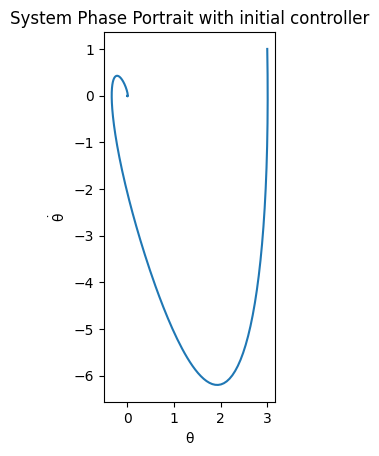

---------------------Sampling Training Data---------------------


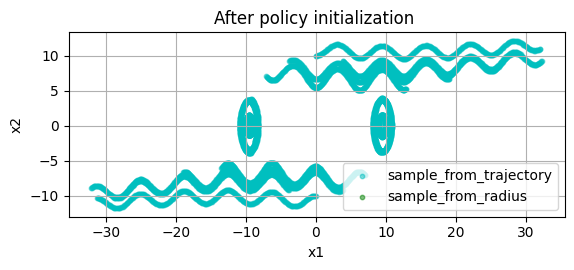

In [3]:
# 初始化动力学模型，准备收集数据
params={'m': 2,'L': 1, 'b': 0.1}
controller_params = {'K':np.array([[35, 8]])}


p1 = InvertedPendulum(system_params = params,
                      controller_params = controller_params,
                      dt = 0.01, 
                      controller_period = 0.01)


x_initial = torch.tensor([[3],[1]]).to(device)
step_num = 4000
sim_data_ = p1.simulate_rk4(x_initial, step_num, 1,)
p1.convergence_judgment(sim_data_)
p1.plot_phase_portrait(data_sim = sim_data_,
                       arrow_on = False,
                       title = 'System Phase Portrait with initial controller')

d1 = learningProcess(system=p1,
                      actor_bound=5.0,
                      n_hiddens_policy=128,
                      n_hiddens_critic=128,
                      actor_lr=0.001,
                      critic_lr=0.01)

sample_number_per_trajectory = 300
[sim_data,actions] = d1.sample_training_data(sample_trajectory_number = 16,
                                sample_number_per_trajectory = sample_number_per_trajectory,
                                sample_radius = 10,
                                sample_number_in_radius = 0,
                                invariant_sample = 1,
                                sample_plot = 1,
                                the_controller = d1.actor.Controller,
                                title = 'After policy initialization ')



---------------------Sampling Training Data---------------------


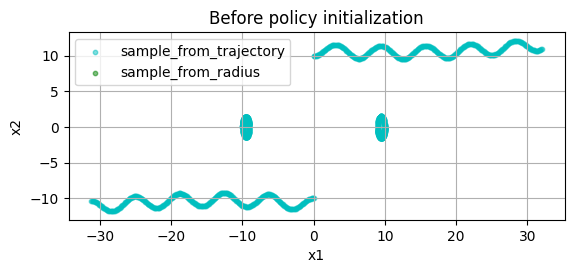

---------------------Initializing Policy------------------------
Epoch [1000/10000], Loss: 0.0183979925
Epoch [2000/10000], Loss: 0.0081793452
Epoch [3000/10000], Loss: 0.0058690216
Epoch [4000/10000], Loss: 0.0048212302
Epoch [5000/10000], Loss: 0.0041995035
Epoch [6000/10000], Loss: 0.0037880756
Epoch [7000/10000], Loss: 0.0034835134
Epoch [8000/10000], Loss: 0.0032494173
Epoch [9000/10000], Loss: 0.0030602997
Epoch [10000/10000], Loss: 0.0029071134
-----------------It takes 233 steps to converge.------------------


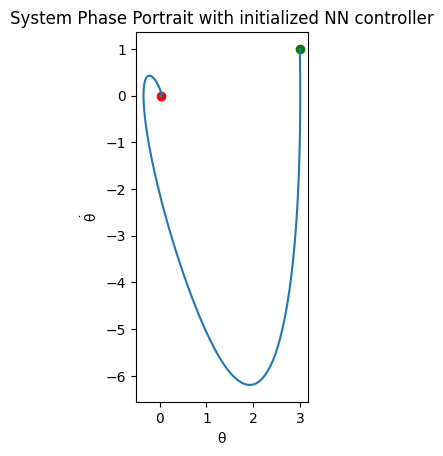

---------------------Sampling Training Data---------------------


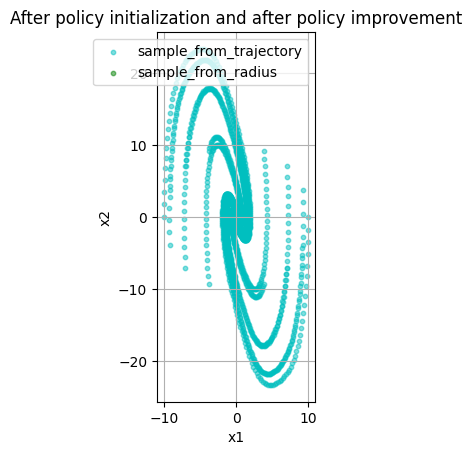

In [4]:
_ = d1.sample_training_data(sample_trajectory_number = 4,
                            sample_number_per_trajectory = 300,
                            sample_radius = 10,
                            sample_number_in_radius = 0,
                            invariant_sample = 1,
                            sample_plot = 1,
                            the_controller = d1.actor.Controller,
                            title='Before policy initialization')


d1.initialize_policy_net(x_train_lim = 10,
                         x_test_lim = 13,
                         sample_num = 1000,
                         iteration = 10**4,
                         lr = 1e-3)


x_initial = torch.tensor([[3],[1]]).to(device)
step_num = 4000
sim_data_ = p1.simulate_rk4(x_initial = x_initial, 
                           step_number = step_num,
                           use_controller = 1,
                           the_controller = d1.actor.Controller)
stepconverge_initial = p1.convergence_judgment(sim_data_)
p1.plot_phase_portrait_2(data_sim = sim_data_,
                       arrow_on = False,
                       title = 'System Phase Portrait with initialized NN controller')


[sim_data,actions] = d1.sample_training_data(sample_trajectory_number = 16,
                                sample_number_per_trajectory = sample_number_per_trajectory,
                                sample_radius = 10,
                                sample_number_in_radius = 0,
                                invariant_sample = 1,
                                sample_plot = 1,
                                the_controller = d1.actor.Controller,
                                title = 'After policy initialization')

第1次迭代
--------------------------Updating policy by PPO--------------------------


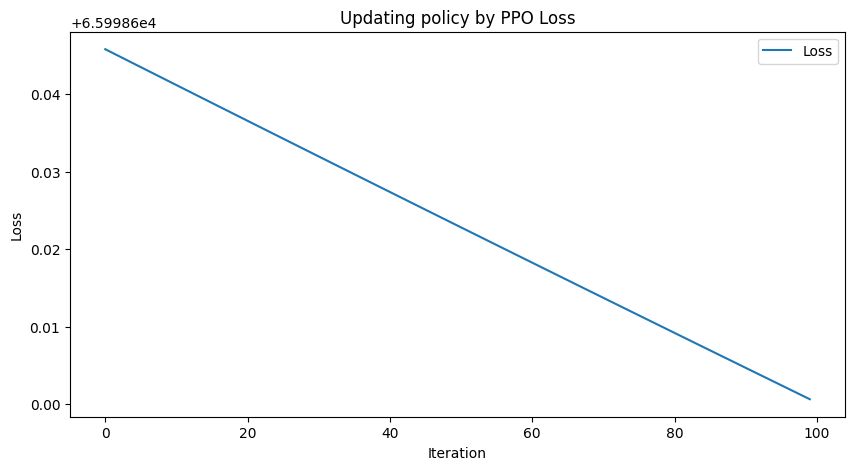

--------------------------Learning Value function--------------------------
Epoch [1000/10000], Loss: 115.4884262085
Epoch [2000/10000], Loss: 115.4654693604
Epoch [3000/10000], Loss: 115.4501571655
Epoch [4000/10000], Loss: 115.4420166016
Epoch [5000/10000], Loss: 115.4351196289
Epoch [6000/10000], Loss: 115.4272155762
Epoch [7000/10000], Loss: 115.4180984497
Epoch [8000/10000], Loss: 115.4098815918
Epoch [9000/10000], Loss: 115.4046707153
Epoch [10000/10000], Loss: 115.3986282349


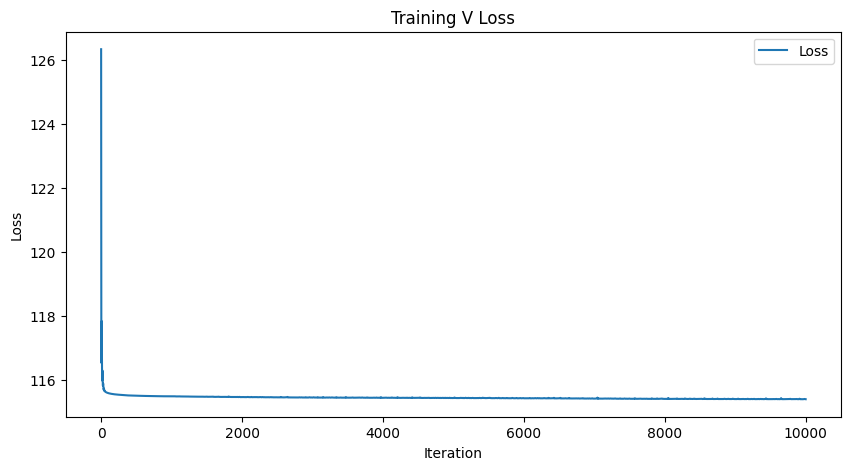

---------------------Sampling Training Data---------------------


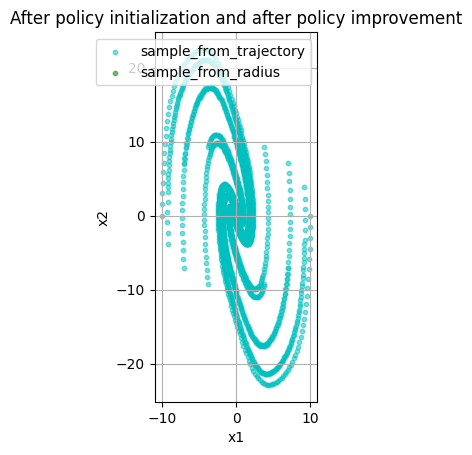

-----------------It takes 258 steps to converge.------------------


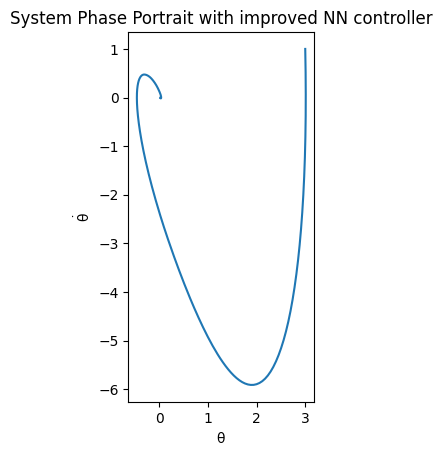

第2次迭代
--------------------------Updating policy by PPO--------------------------


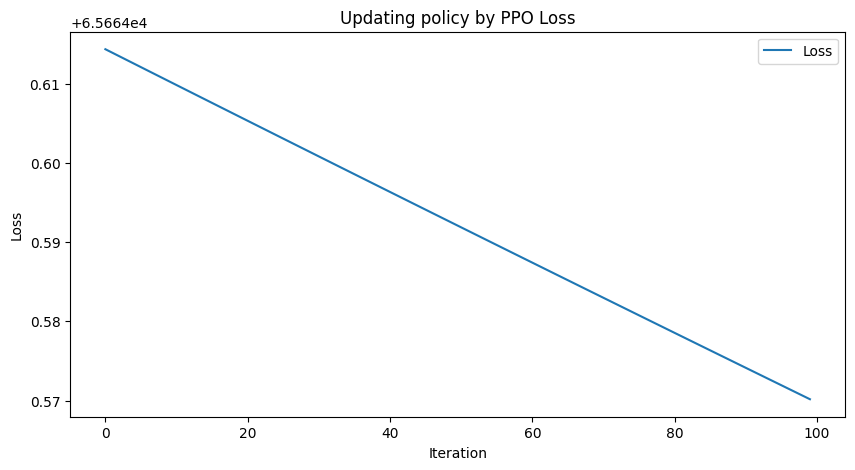

--------------------------Learning Value function--------------------------
Epoch [1000/10000], Loss: 115.0330505371
Epoch [2000/10000], Loss: 114.9889221191
Epoch [3000/10000], Loss: 114.9485549927
Epoch [4000/10000], Loss: 114.8944396973
Epoch [5000/10000], Loss: 114.8347244263
Epoch [6000/10000], Loss: 114.7773208618
Epoch [7000/10000], Loss: 114.7563858032
Epoch [8000/10000], Loss: 114.7143325806
Epoch [9000/10000], Loss: 114.7053680420
Epoch [10000/10000], Loss: 114.6921539307


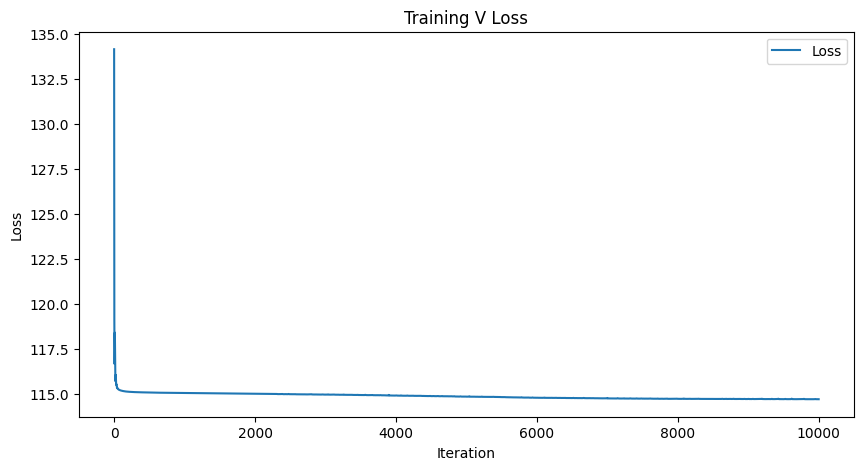

---------------------Sampling Training Data---------------------


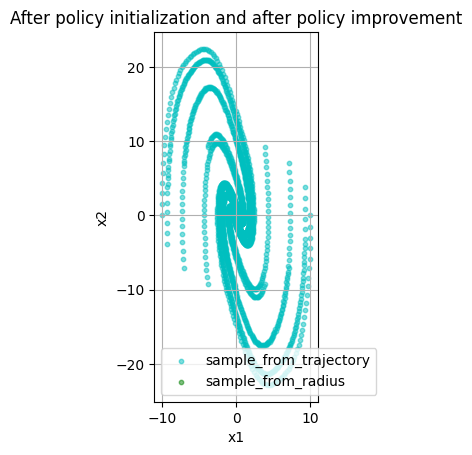

-----------------It takes 263 steps to converge.------------------


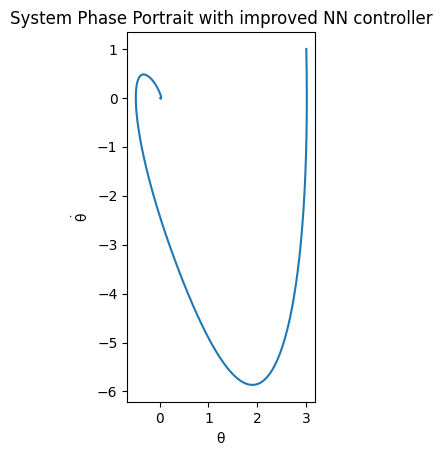

第3次迭代
--------------------------Updating policy by PPO--------------------------


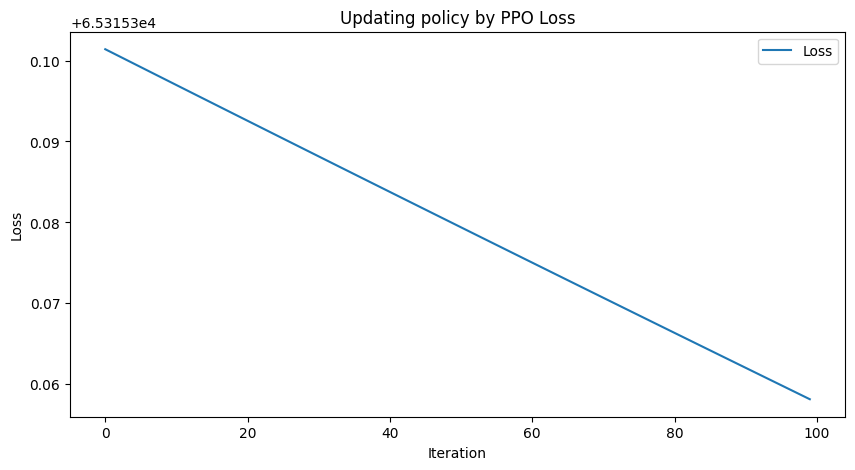

--------------------------Learning Value function--------------------------
Epoch [1000/10000], Loss: 114.2826766968
Epoch [2000/10000], Loss: 114.2112808228
Epoch [3000/10000], Loss: 114.1827926636
Epoch [4000/10000], Loss: 114.1510925293
Epoch [5000/10000], Loss: 114.1198501587
Epoch [6000/10000], Loss: 114.1084594727
Epoch [7000/10000], Loss: 114.0967712402
Epoch [8000/10000], Loss: 114.0869216919
Epoch [9000/10000], Loss: 114.0797958374
Epoch [10000/10000], Loss: 114.0650329590


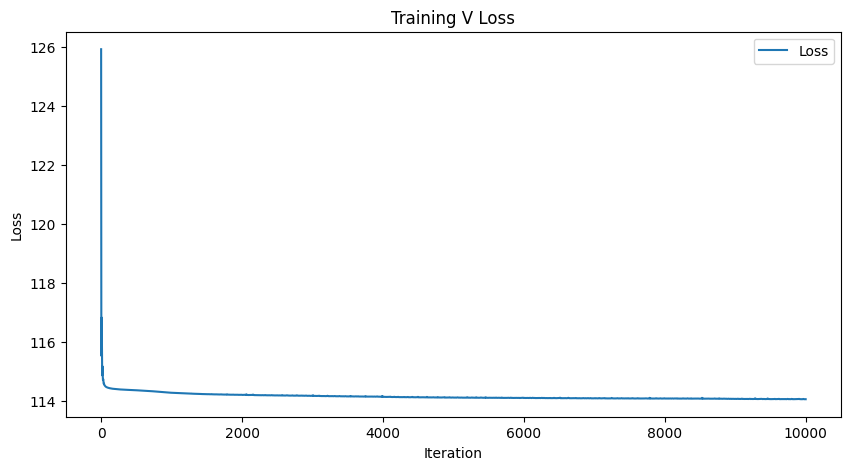

---------------------Sampling Training Data---------------------


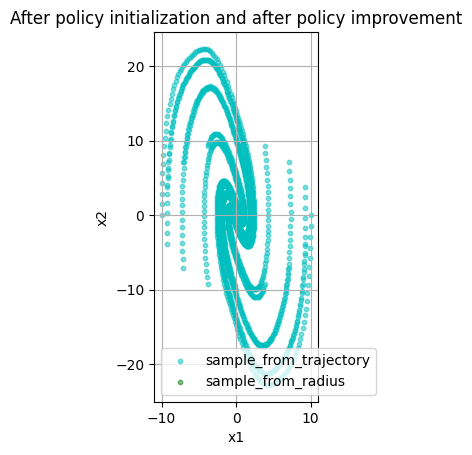

-----------------It takes 268 steps to converge.------------------


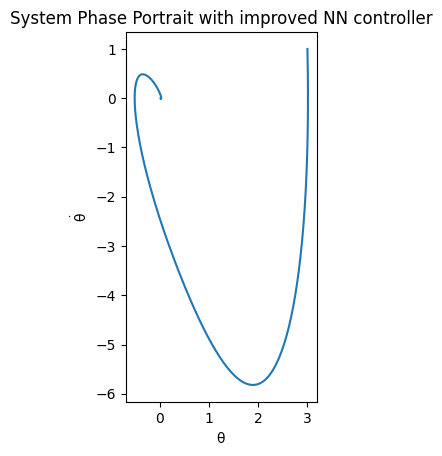

第4次迭代
--------------------------Updating policy by PPO--------------------------


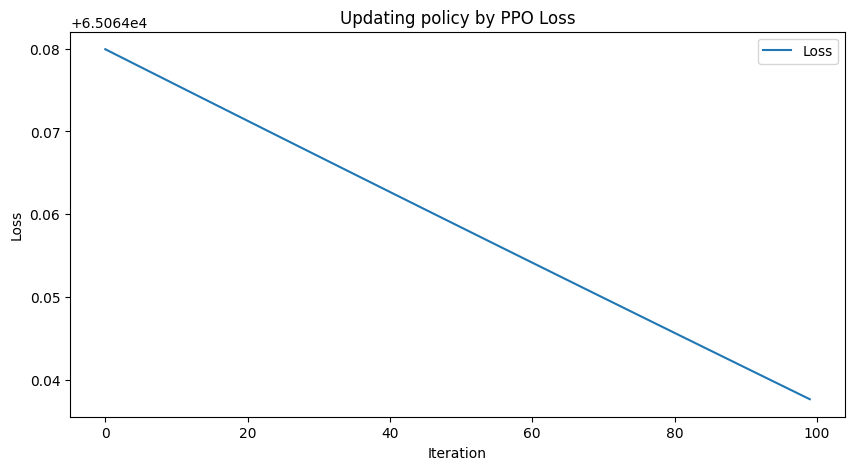

--------------------------Learning Value function--------------------------
Epoch [1000/10000], Loss: 113.8343582153
Epoch [2000/10000], Loss: 113.8097763062
Epoch [3000/10000], Loss: 113.7906265259
Epoch [4000/10000], Loss: 113.7583236694
Epoch [5000/10000], Loss: 113.7374114990
Epoch [6000/10000], Loss: 113.7233963013
Epoch [7000/10000], Loss: 113.7135925293
Epoch [8000/10000], Loss: 113.6983642578
Epoch [9000/10000], Loss: 113.6822357178
Epoch [10000/10000], Loss: 113.6781387329


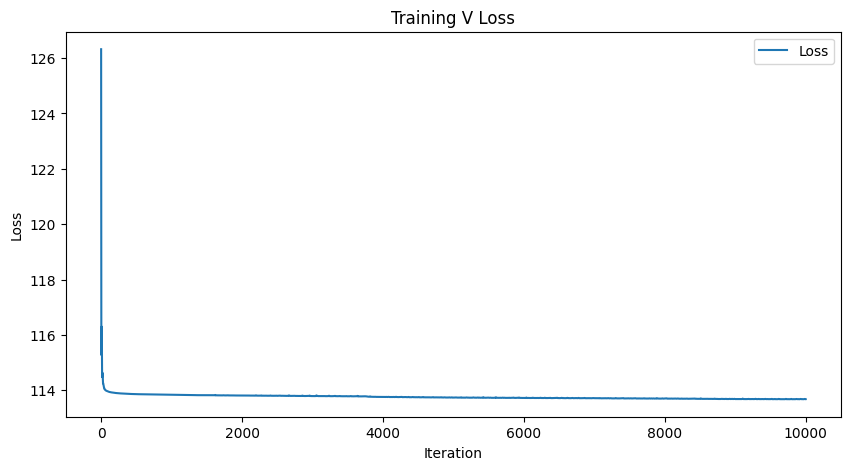

---------------------Sampling Training Data---------------------


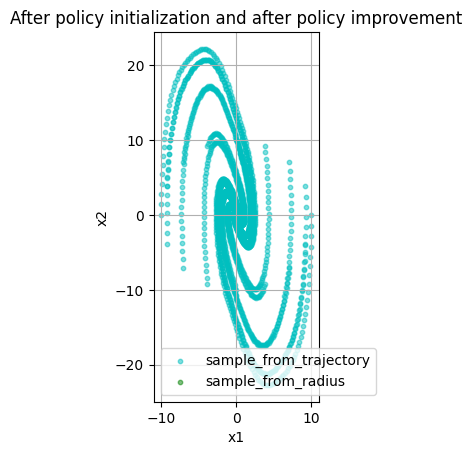

-----------------It takes 273 steps to converge.------------------


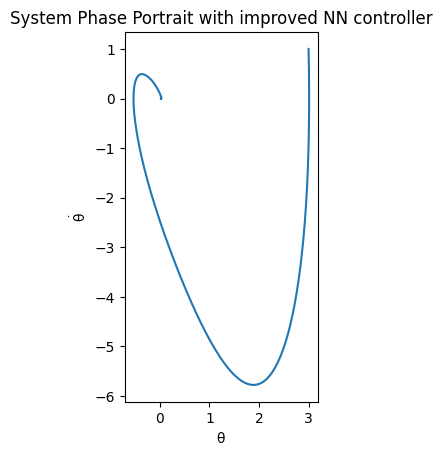

第5次迭代
--------------------------Updating policy by PPO--------------------------


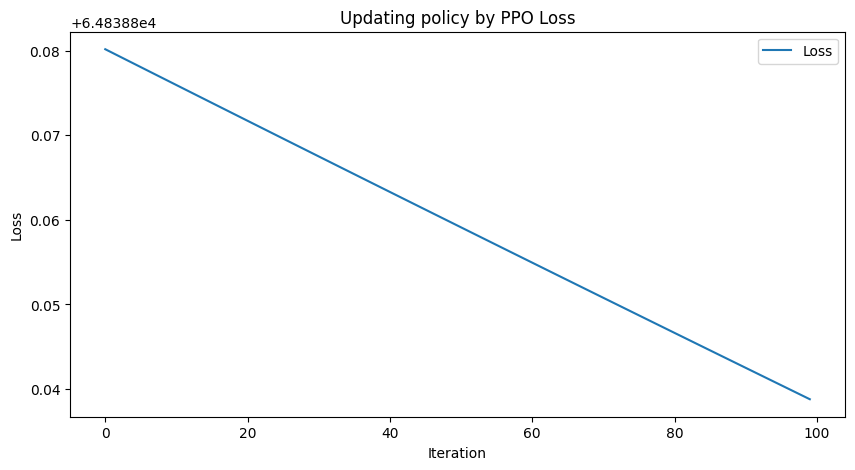

--------------------------Learning Value function--------------------------
Epoch [1000/10000], Loss: 113.4358367920
Epoch [2000/10000], Loss: 113.3810653687
Epoch [3000/10000], Loss: 113.3663864136
Epoch [4000/10000], Loss: 113.3602447510
Epoch [5000/10000], Loss: 113.3511810303
Epoch [6000/10000], Loss: 113.3491821289
Epoch [7000/10000], Loss: 113.3426208496
Epoch [8000/10000], Loss: 113.3373565674
Epoch [9000/10000], Loss: 113.3308639526
Epoch [10000/10000], Loss: 113.3301086426


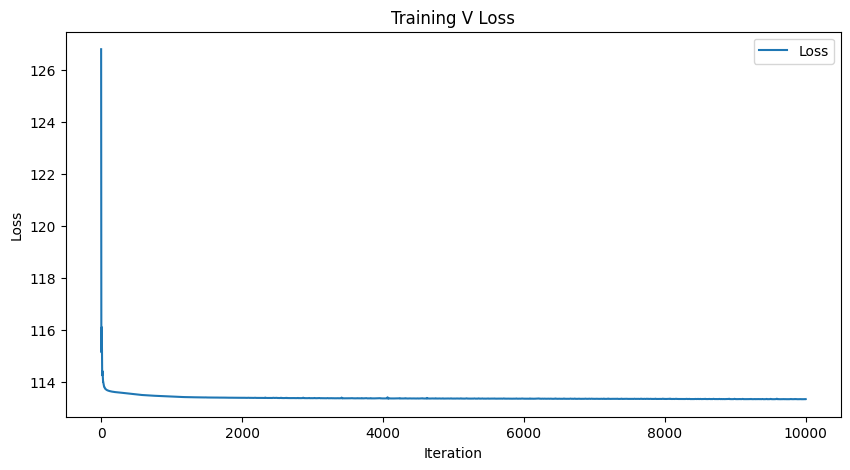

---------------------Sampling Training Data---------------------


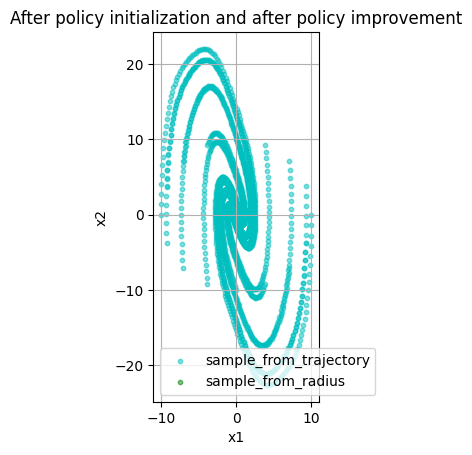

-----------------It takes 278 steps to converge.------------------


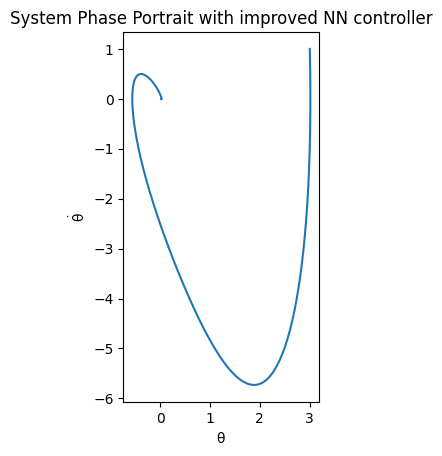

第6次迭代
--------------------------Updating policy by PPO--------------------------


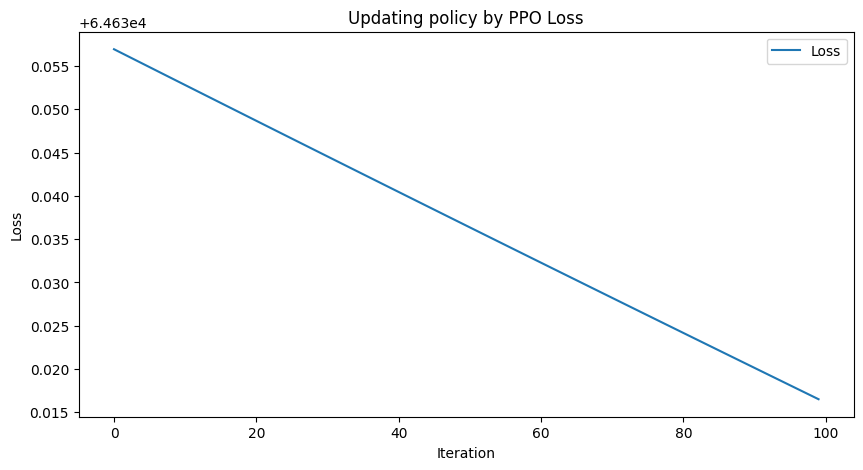

--------------------------Learning Value function--------------------------
Epoch [1000/10000], Loss: 113.1740188599
Epoch [2000/10000], Loss: 113.1402969360
Epoch [3000/10000], Loss: 113.1224822998
Epoch [4000/10000], Loss: 113.1075057983
Epoch [5000/10000], Loss: 113.0840377808
Epoch [6000/10000], Loss: 113.0005035400
Epoch [7000/10000], Loss: 112.9562149048
Epoch [8000/10000], Loss: 112.9159774780
Epoch [9000/10000], Loss: 112.8972930908
Epoch [10000/10000], Loss: 112.8881530762


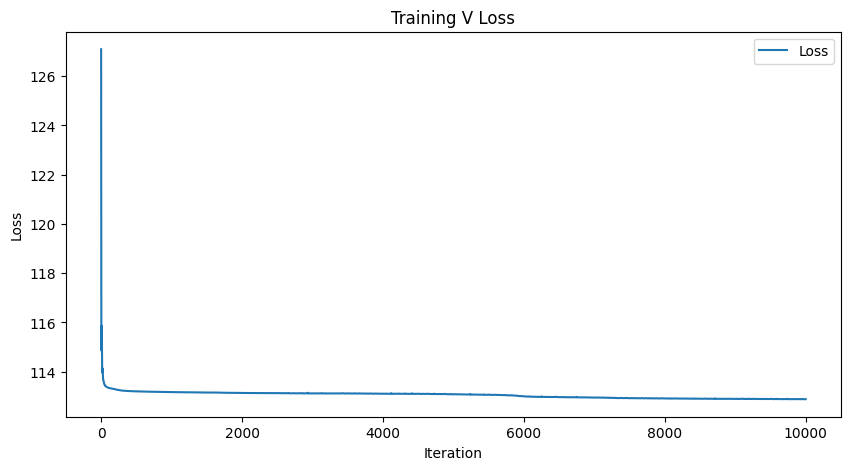

---------------------Sampling Training Data---------------------


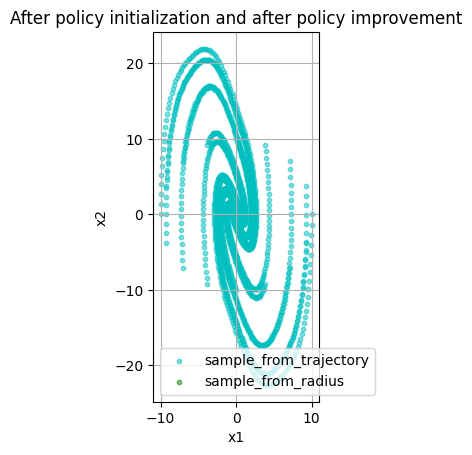

-----------------It takes 283 steps to converge.------------------


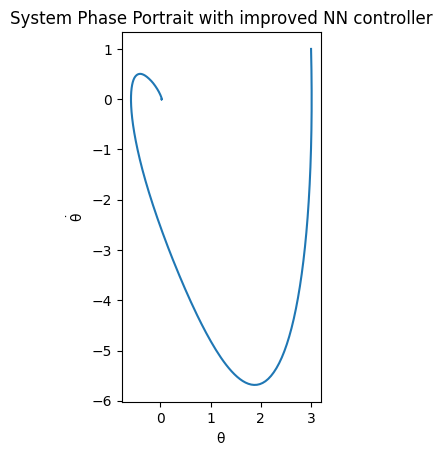

第7次迭代
--------------------------Updating policy by PPO--------------------------


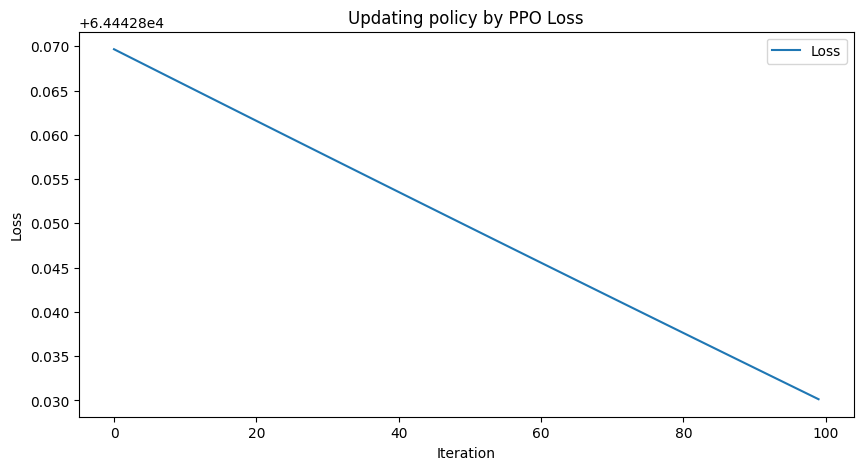

--------------------------Learning Value function--------------------------
Epoch [1000/10000], Loss: 112.8545150757
Epoch [2000/10000], Loss: 112.8133163452
Epoch [3000/10000], Loss: 112.7894210815
Epoch [4000/10000], Loss: 112.7648696899
Epoch [5000/10000], Loss: 112.7563095093
Epoch [6000/10000], Loss: 112.7477874756
Epoch [7000/10000], Loss: 112.7512969971
Epoch [8000/10000], Loss: 112.7396392822
Epoch [9000/10000], Loss: 112.7390441895
Epoch [10000/10000], Loss: 112.7351074219


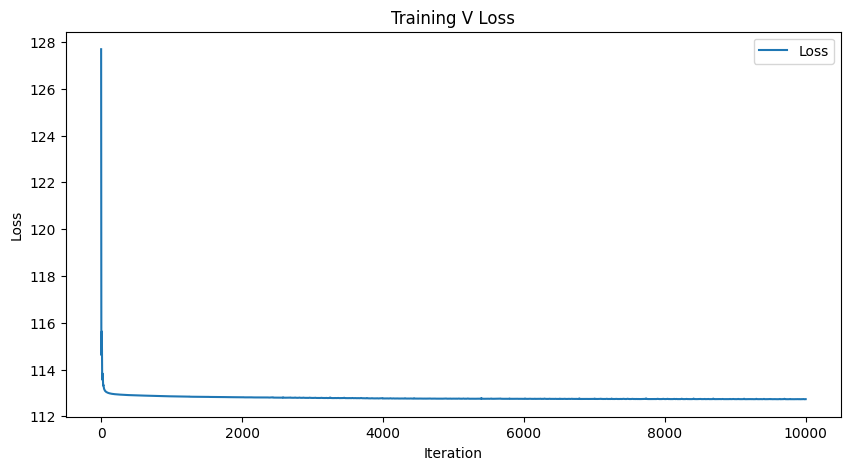

---------------------Sampling Training Data---------------------


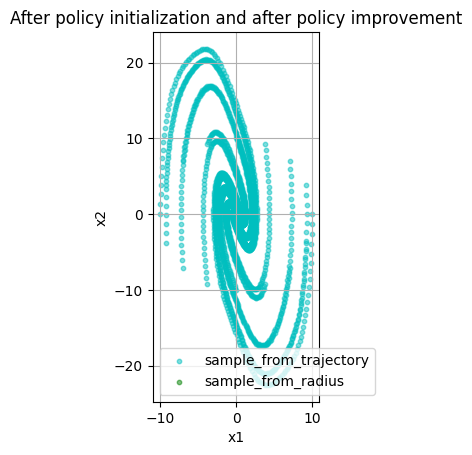

-----------------It takes 289 steps to converge.------------------


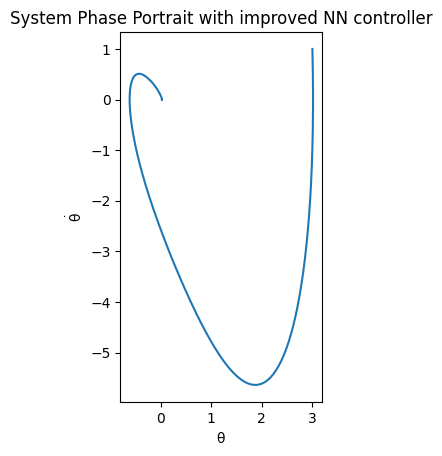

第8次迭代
--------------------------Updating policy by PPO--------------------------


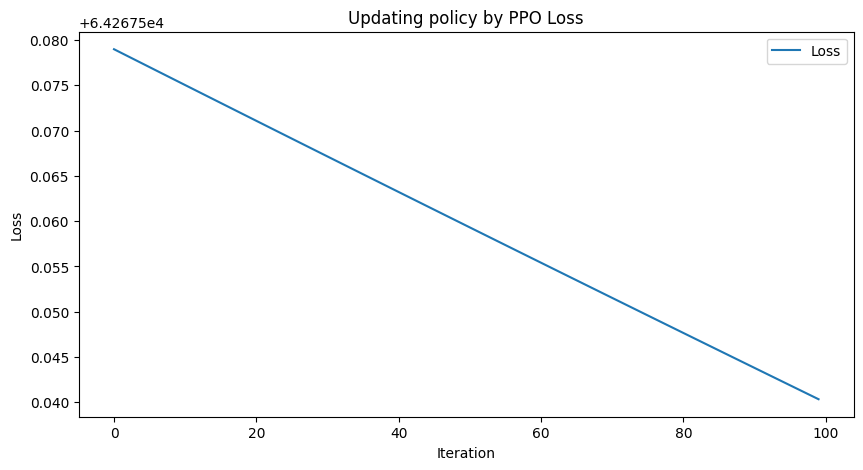

--------------------------Learning Value function--------------------------
Epoch [1000/10000], Loss: 112.8082809448
Epoch [2000/10000], Loss: 112.7529449463
Epoch [3000/10000], Loss: 112.7245178223
Epoch [4000/10000], Loss: 112.7128906250
Epoch [5000/10000], Loss: 112.7035598755
Epoch [6000/10000], Loss: 112.6637115479
Epoch [7000/10000], Loss: 112.6522827148
Epoch [8000/10000], Loss: 112.6470947266
Epoch [9000/10000], Loss: 112.6360015869
Epoch [10000/10000], Loss: 112.6295166016


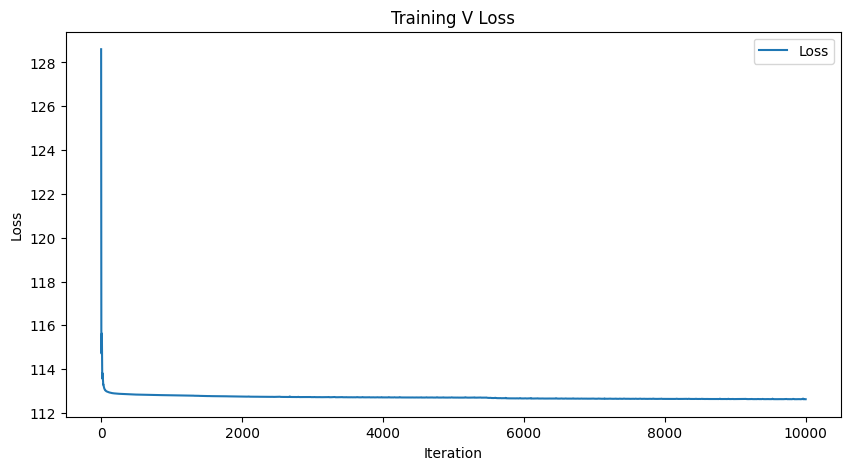

---------------------Sampling Training Data---------------------


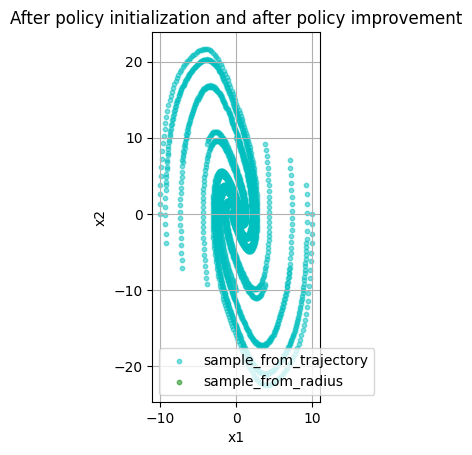

-----------------It takes 295 steps to converge.------------------


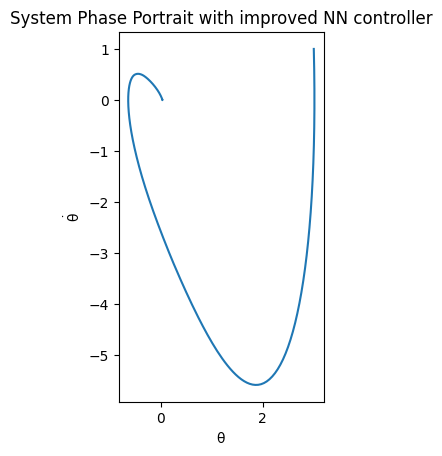

第9次迭代
--------------------------Updating policy by PPO--------------------------


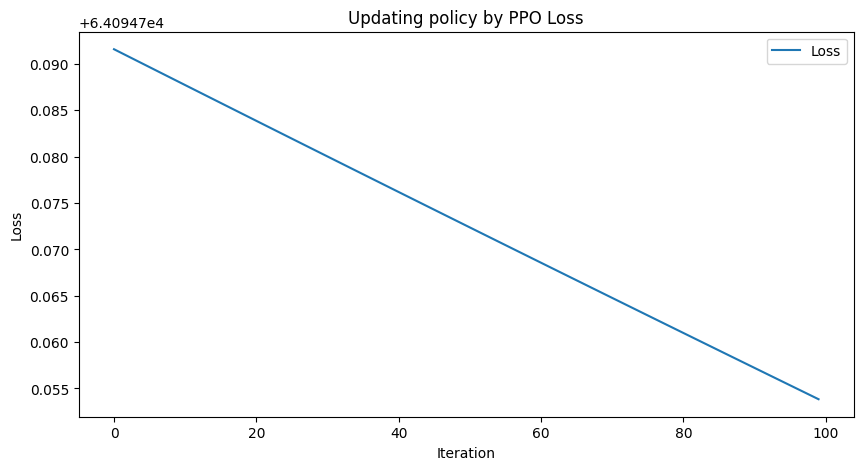

--------------------------Learning Value function--------------------------
Epoch [1000/10000], Loss: 112.7267150879
Epoch [2000/10000], Loss: 112.6889266968
Epoch [3000/10000], Loss: 112.6610412598
Epoch [4000/10000], Loss: 112.6305847168
Epoch [5000/10000], Loss: 112.5719680786
Epoch [6000/10000], Loss: 112.5502624512
Epoch [7000/10000], Loss: 112.5404052734
Epoch [8000/10000], Loss: 112.5279464722
Epoch [9000/10000], Loss: 112.5223388672
Epoch [10000/10000], Loss: 112.5168991089


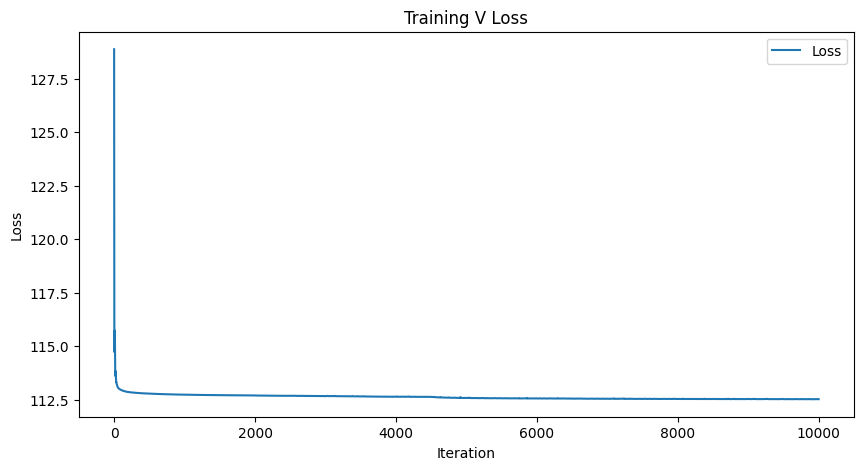

---------------------Sampling Training Data---------------------


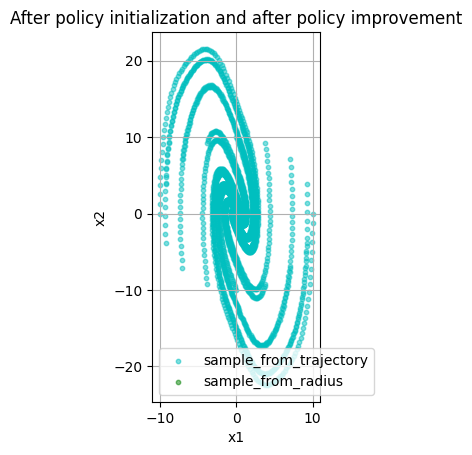

-----------------It takes 300 steps to converge.------------------


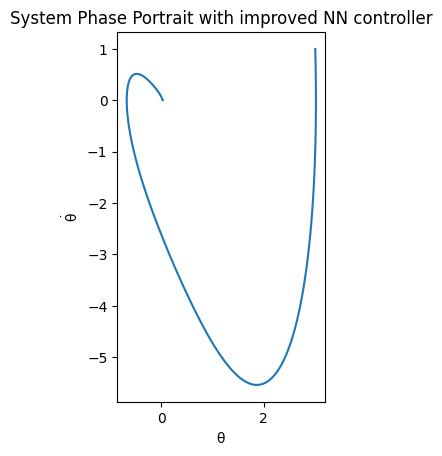

第10次迭代
--------------------------Updating policy by PPO--------------------------


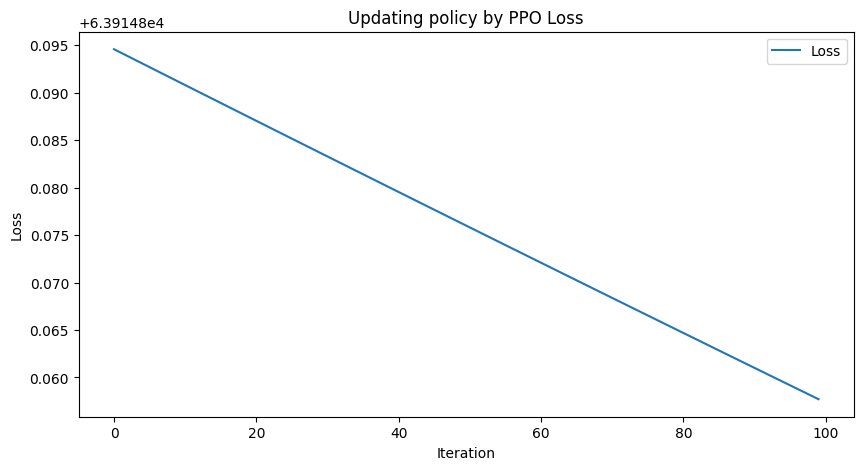

--------------------------Learning Value function--------------------------
Epoch [1000/10000], Loss: 112.7031021118
Epoch [2000/10000], Loss: 112.6536407471
Epoch [3000/10000], Loss: 112.6134719849
Epoch [4000/10000], Loss: 112.5925521851
Epoch [5000/10000], Loss: 112.5731506348
Epoch [6000/10000], Loss: 112.5567016602
Epoch [7000/10000], Loss: 112.5437164307
Epoch [8000/10000], Loss: 112.5406341553
Epoch [9000/10000], Loss: 112.5246124268
Epoch [10000/10000], Loss: 112.5185012817


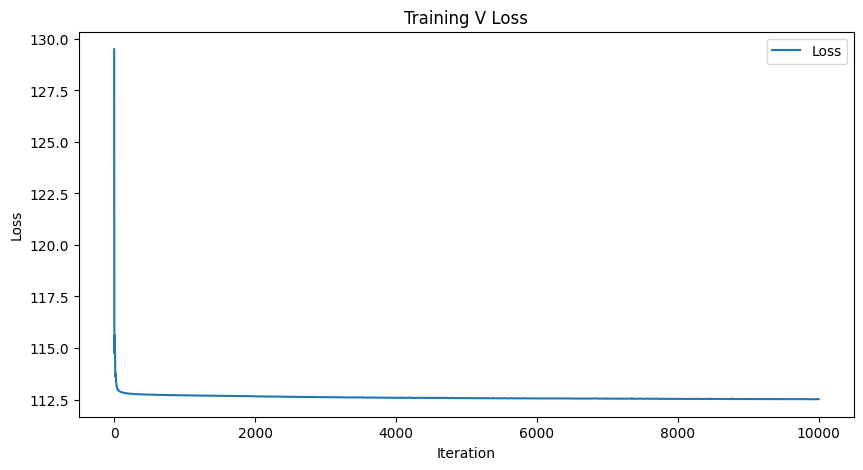

---------------------Sampling Training Data---------------------


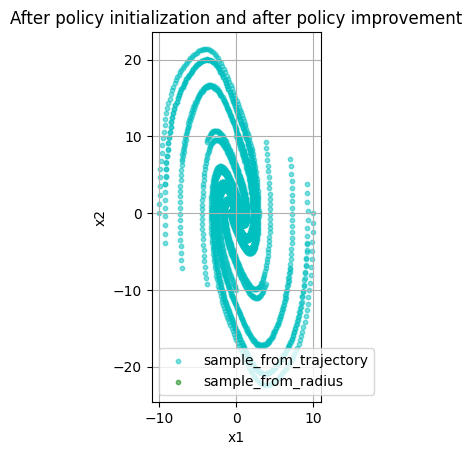

-----------------It takes 307 steps to converge.------------------


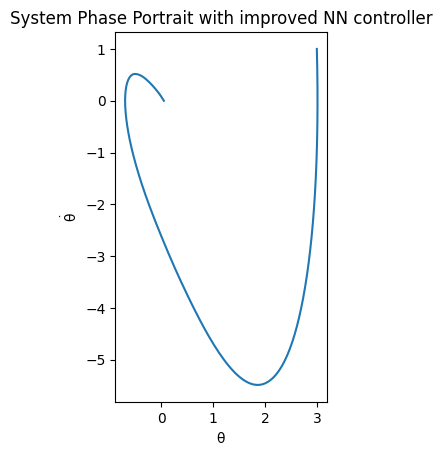

第11次迭代
--------------------------Updating policy by PPO--------------------------


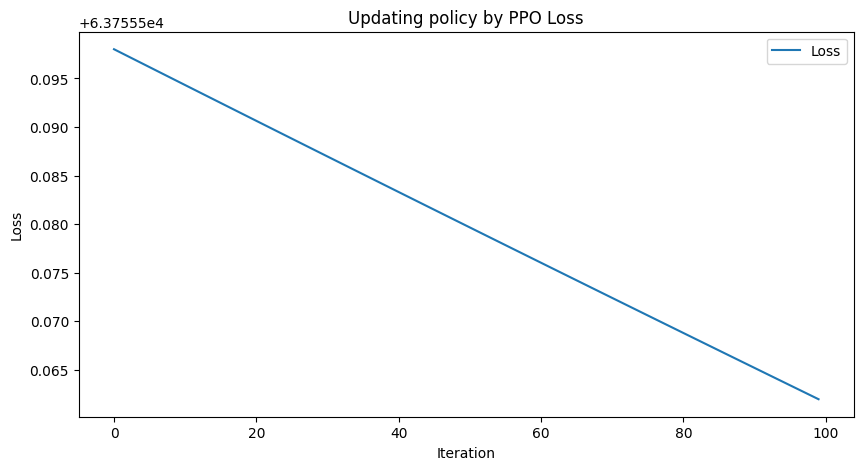

--------------------------Learning Value function--------------------------
Epoch [1000/10000], Loss: 112.8387222290
Epoch [2000/10000], Loss: 112.7813034058
Epoch [3000/10000], Loss: 112.7415466309
Epoch [4000/10000], Loss: 112.7115325928
Epoch [5000/10000], Loss: 112.6971893311
Epoch [6000/10000], Loss: 112.6892852783
Epoch [7000/10000], Loss: 112.6832580566
Epoch [8000/10000], Loss: 112.6574325562
Epoch [9000/10000], Loss: 112.6195678711
Epoch [10000/10000], Loss: 112.6060028076


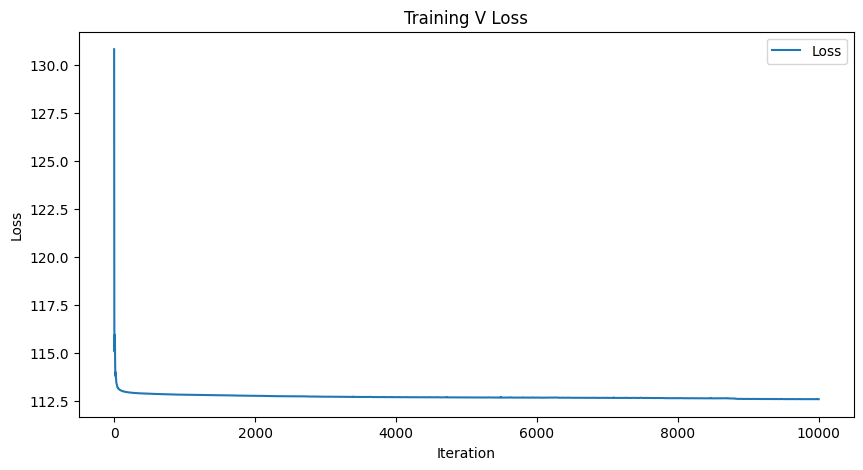

---------------------Sampling Training Data---------------------


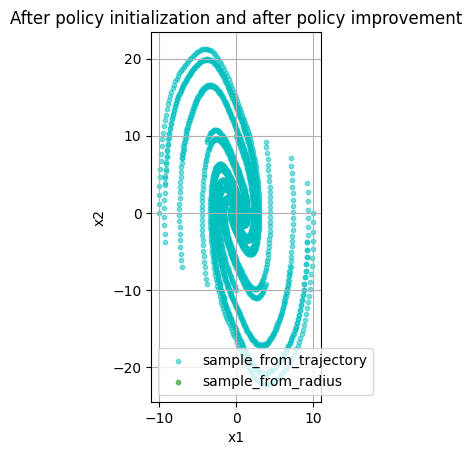

-----------------It takes 314 steps to converge.------------------


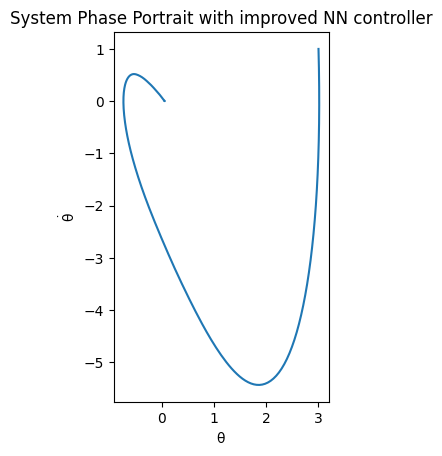

第12次迭代
--------------------------Updating policy by PPO--------------------------


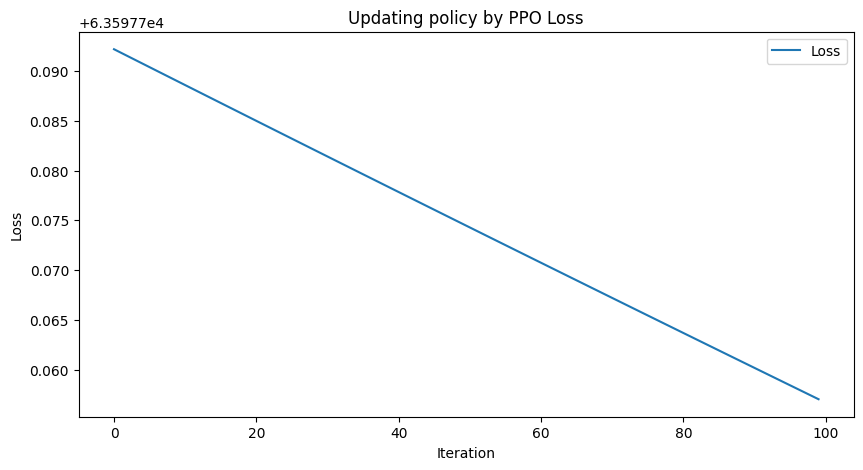

--------------------------Learning Value function--------------------------
Epoch [1000/10000], Loss: 113.0551147461
Epoch [2000/10000], Loss: 112.9848709106
Epoch [3000/10000], Loss: 112.9419708252
Epoch [4000/10000], Loss: 112.9040222168
Epoch [5000/10000], Loss: 112.8769836426
Epoch [6000/10000], Loss: 112.8600006104
Epoch [7000/10000], Loss: 112.8253936768
Epoch [8000/10000], Loss: 112.7899780273
Epoch [9000/10000], Loss: 112.7742156982
Epoch [10000/10000], Loss: 112.7559890747


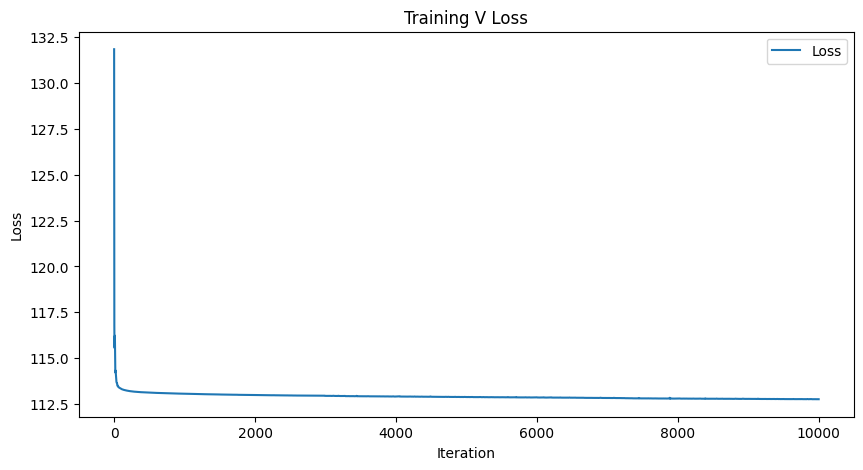

---------------------Sampling Training Data---------------------


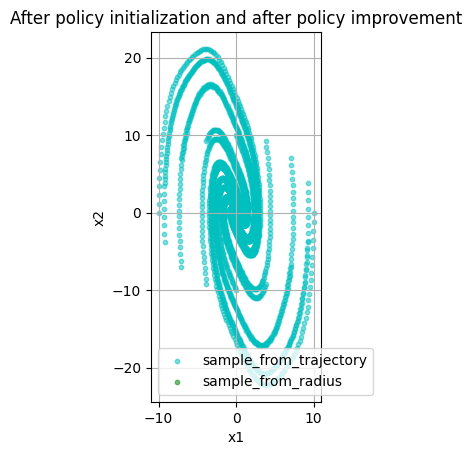

-----------------It takes 324 steps to converge.------------------


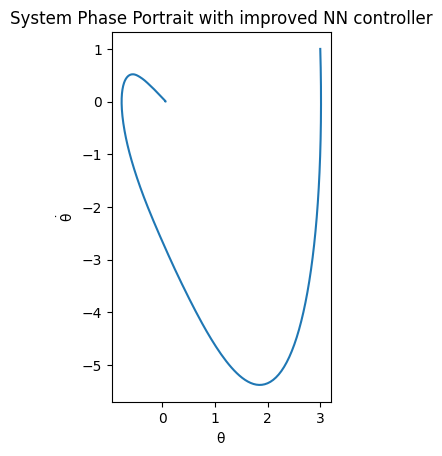

第13次迭代
--------------------------Updating policy by PPO--------------------------


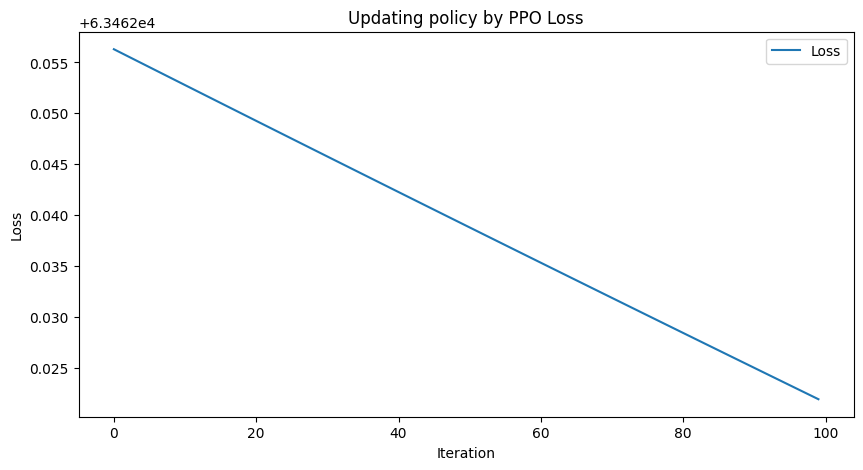

--------------------------Learning Value function--------------------------
Epoch [1000/10000], Loss: 113.5615158081
Epoch [2000/10000], Loss: 113.4151458740
Epoch [3000/10000], Loss: 113.3753814697
Epoch [4000/10000], Loss: 113.3490676880
Epoch [5000/10000], Loss: 113.3379592896
Epoch [6000/10000], Loss: 113.3208160400
Epoch [7000/10000], Loss: 113.3169097900
Epoch [8000/10000], Loss: 113.3088150024
Epoch [9000/10000], Loss: 113.3018188477
Epoch [10000/10000], Loss: 113.2995452881


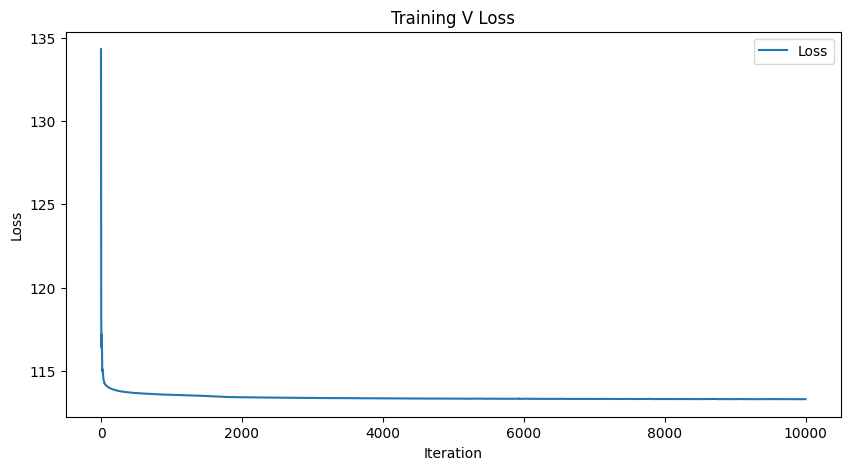

---------------------Sampling Training Data---------------------


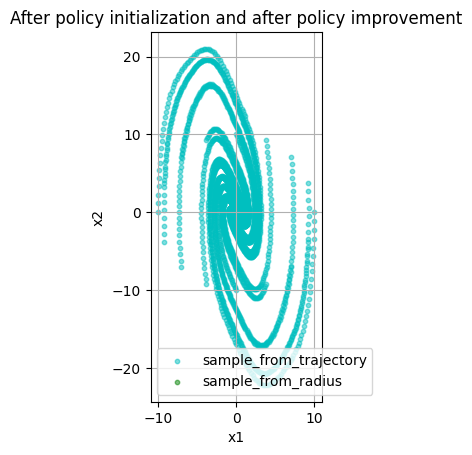

-----------------It takes 332 steps to converge.------------------


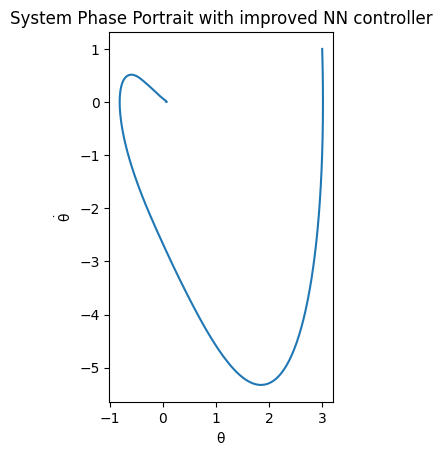

第14次迭代
--------------------------Updating policy by PPO--------------------------


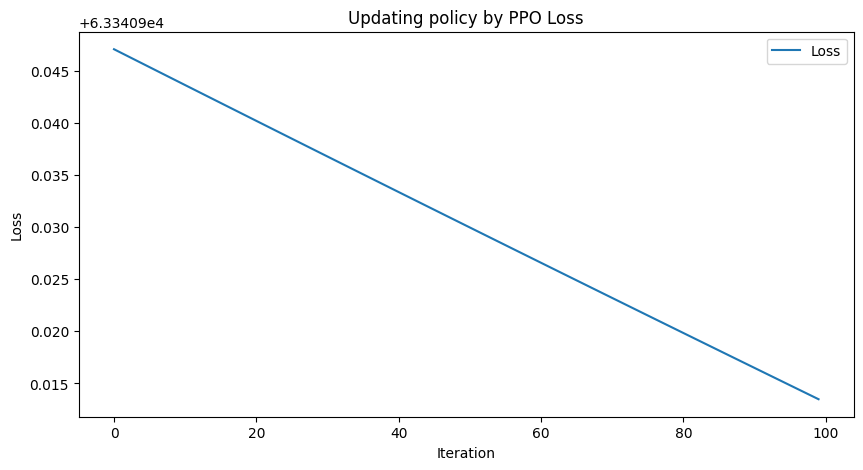

--------------------------Learning Value function--------------------------
Epoch [1000/10000], Loss: 114.6746749878
Epoch [2000/10000], Loss: 114.4569854736
Epoch [3000/10000], Loss: 114.3886413574
Epoch [4000/10000], Loss: 114.3602600098
Epoch [5000/10000], Loss: 114.3473968506
Epoch [6000/10000], Loss: 114.3326034546
Epoch [7000/10000], Loss: 114.3210067749
Epoch [8000/10000], Loss: 114.3096618652
Epoch [9000/10000], Loss: 114.2999114990
Epoch [10000/10000], Loss: 114.2863845825


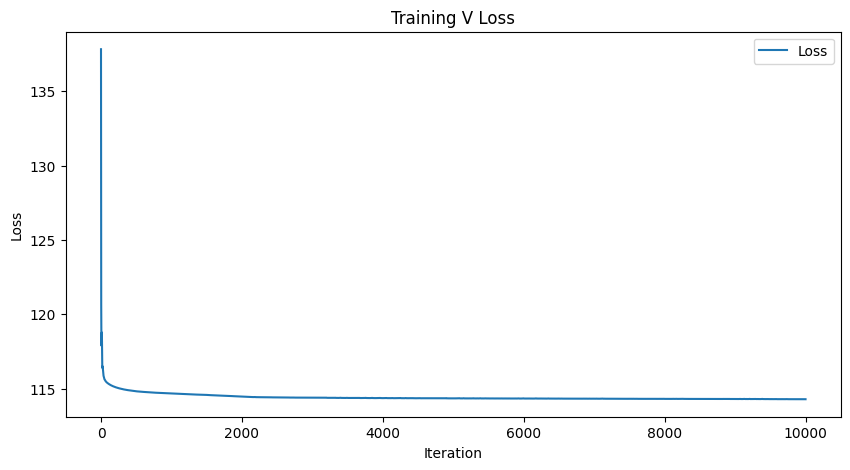

---------------------Sampling Training Data---------------------


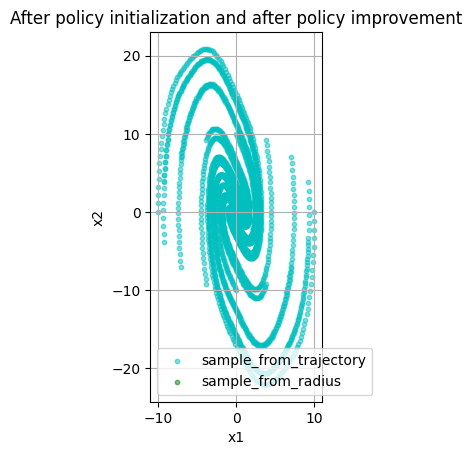

-----------------It takes 338 steps to converge.------------------


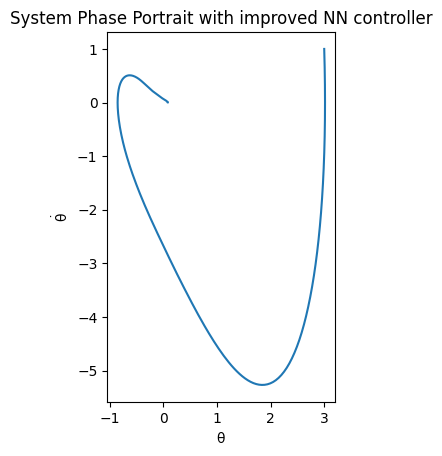

第15次迭代
--------------------------Updating policy by PPO--------------------------


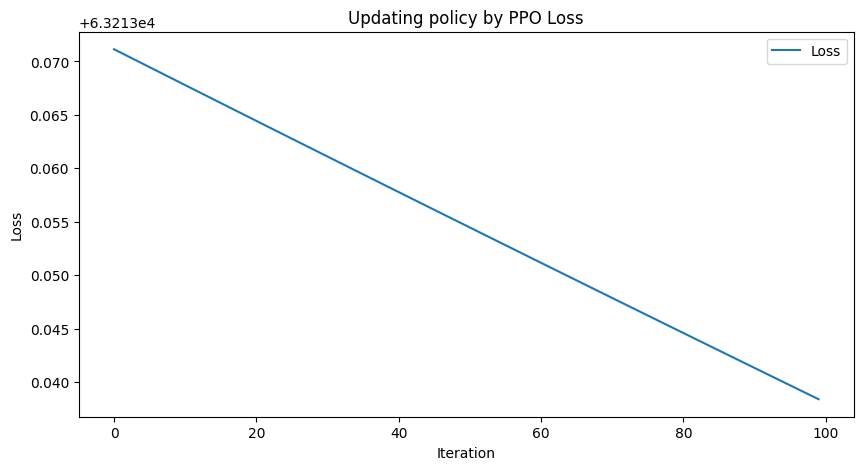

--------------------------Learning Value function--------------------------
Epoch [1000/10000], Loss: 116.1869735718
Epoch [2000/10000], Loss: 115.8871231079
Epoch [3000/10000], Loss: 115.6486434937
Epoch [4000/10000], Loss: 115.0859069824
Epoch [5000/10000], Loss: 115.0253448486
Epoch [6000/10000], Loss: 114.9935913086
Epoch [7000/10000], Loss: 114.9729156494
Epoch [8000/10000], Loss: 114.9536590576
Epoch [9000/10000], Loss: 114.9386672974
Epoch [10000/10000], Loss: 114.9276275635


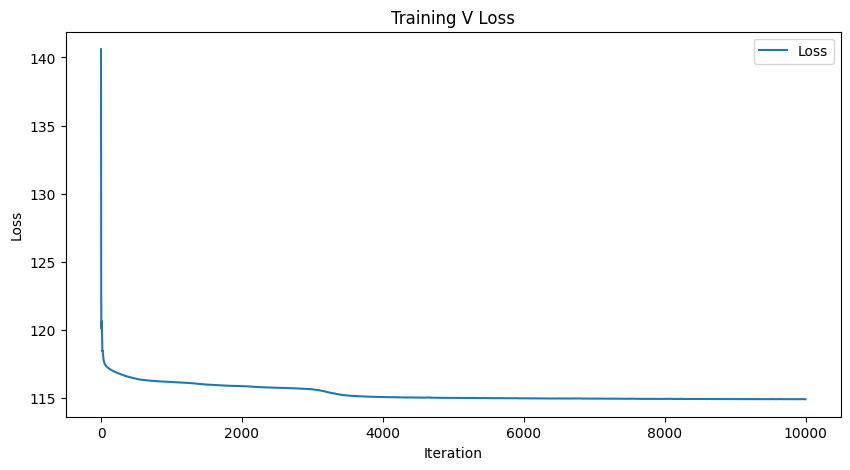

---------------------Sampling Training Data---------------------


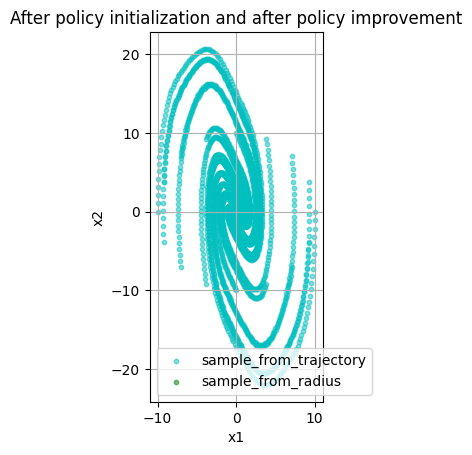

-----------------It takes 352 steps to converge.------------------


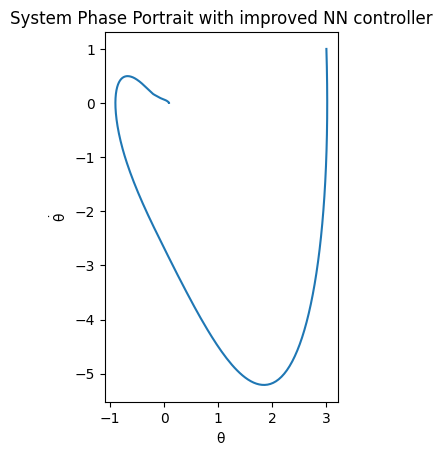

第16次迭代
--------------------------Updating policy by PPO--------------------------


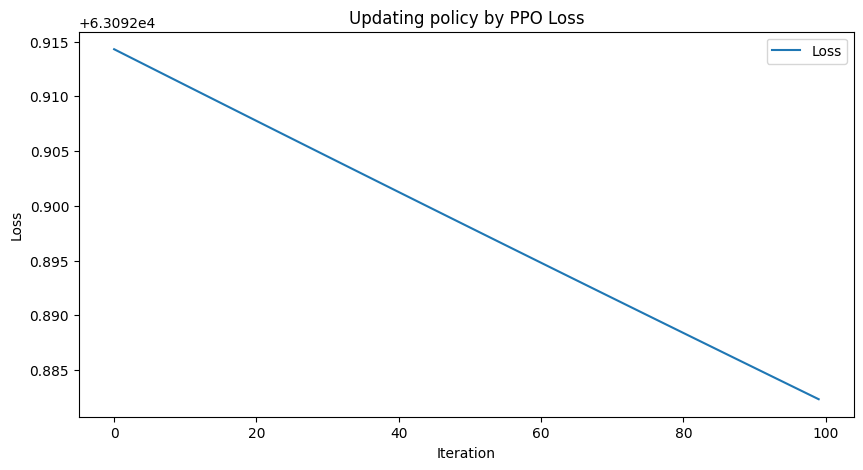

--------------------------Learning Value function--------------------------
Epoch [1000/10000], Loss: 117.2257385254
Epoch [2000/10000], Loss: 116.9138031006
Epoch [3000/10000], Loss: 116.8281250000
Epoch [4000/10000], Loss: 116.8002700806
Epoch [5000/10000], Loss: 116.7661895752
Epoch [6000/10000], Loss: 116.7502975464
Epoch [7000/10000], Loss: 116.7388381958
Epoch [8000/10000], Loss: 116.7228088379
Epoch [9000/10000], Loss: 116.7120819092
Epoch [10000/10000], Loss: 116.7061157227


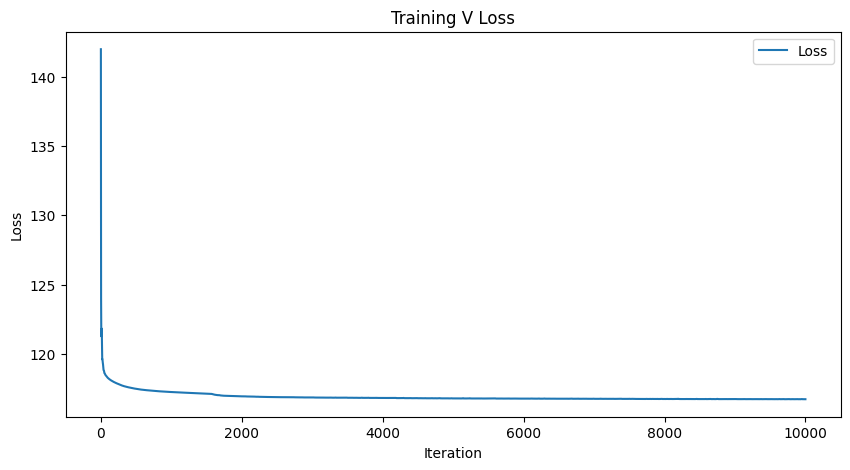

---------------------Sampling Training Data---------------------


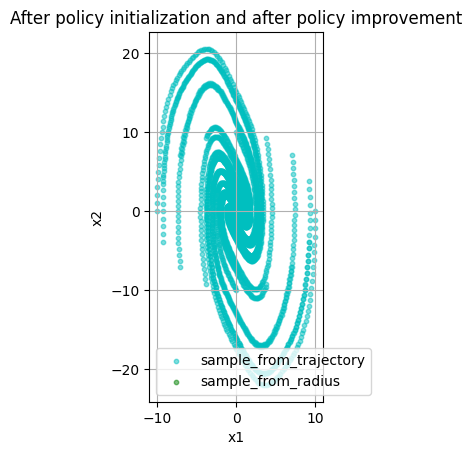

-----------------It takes 370 steps to converge.------------------


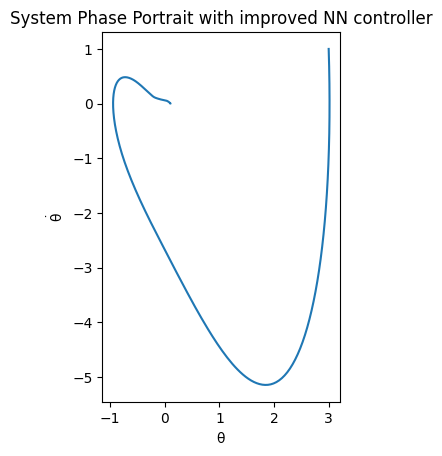

第17次迭代
--------------------------Updating policy by PPO--------------------------


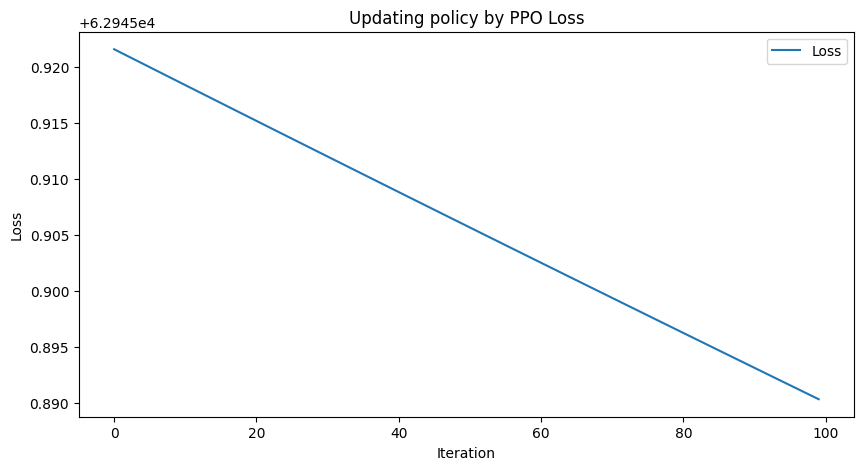

--------------------------Learning Value function--------------------------
Epoch [1000/10000], Loss: 120.1879272461
Epoch [2000/10000], Loss: 119.8323135376
Epoch [3000/10000], Loss: 119.7695083618
Epoch [4000/10000], Loss: 119.7241668701
Epoch [5000/10000], Loss: 119.7052993774
Epoch [6000/10000], Loss: 119.6875991821
Epoch [7000/10000], Loss: 119.6657485962
Epoch [8000/10000], Loss: 119.6557922363
Epoch [9000/10000], Loss: 119.6519470215
Epoch [10000/10000], Loss: 119.6472320557


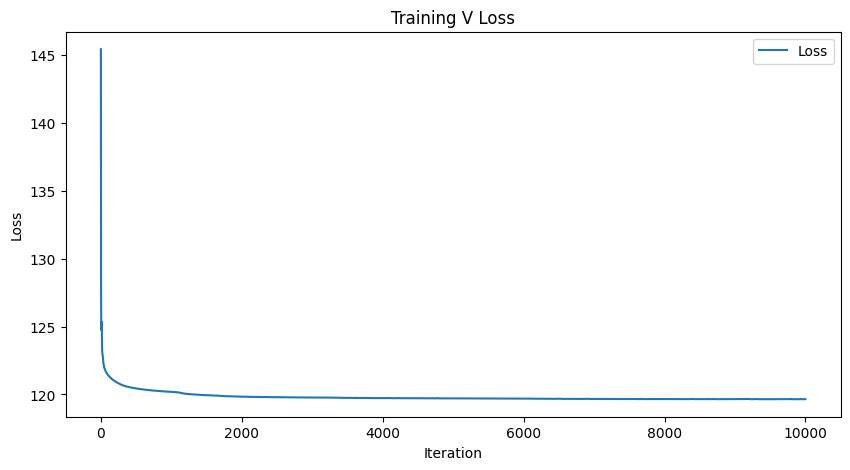

---------------------Sampling Training Data---------------------


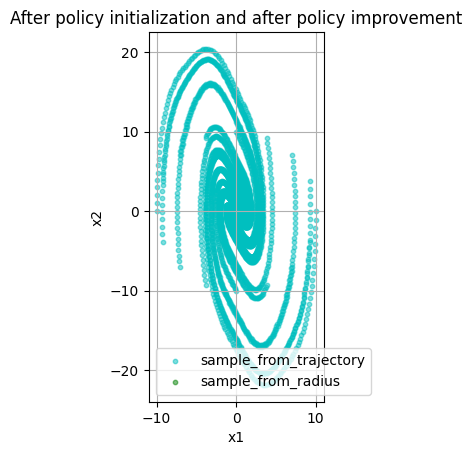

-----------------It takes 390 steps to converge.------------------


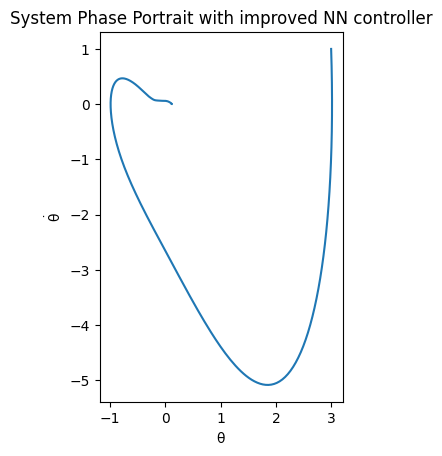

第18次迭代
--------------------------Updating policy by PPO--------------------------


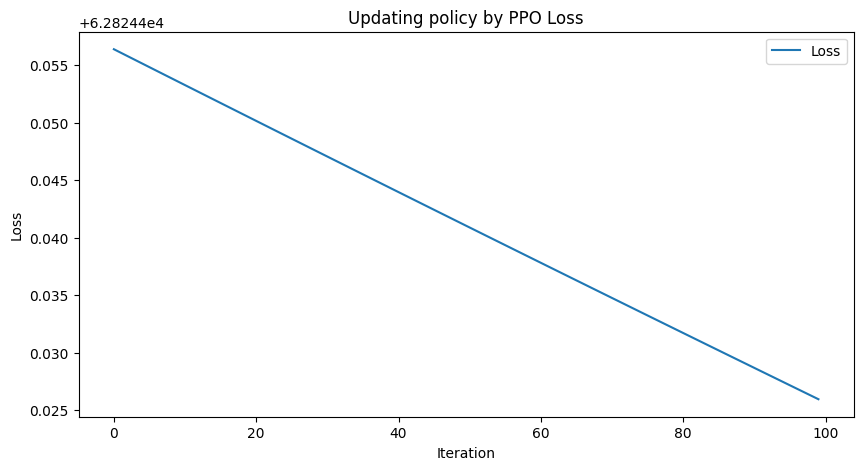

--------------------------Learning Value function--------------------------
Epoch [1000/10000], Loss: 124.4685363770
Epoch [2000/10000], Loss: 124.2267761230
Epoch [3000/10000], Loss: 124.0448684692
Epoch [4000/10000], Loss: 123.9999923706
Epoch [5000/10000], Loss: 123.9847183228
Epoch [6000/10000], Loss: 123.9756164551
Epoch [7000/10000], Loss: 123.9629135132
Epoch [8000/10000], Loss: 123.9616546631
Epoch [9000/10000], Loss: 123.9549255371
Epoch [10000/10000], Loss: 123.9492187500


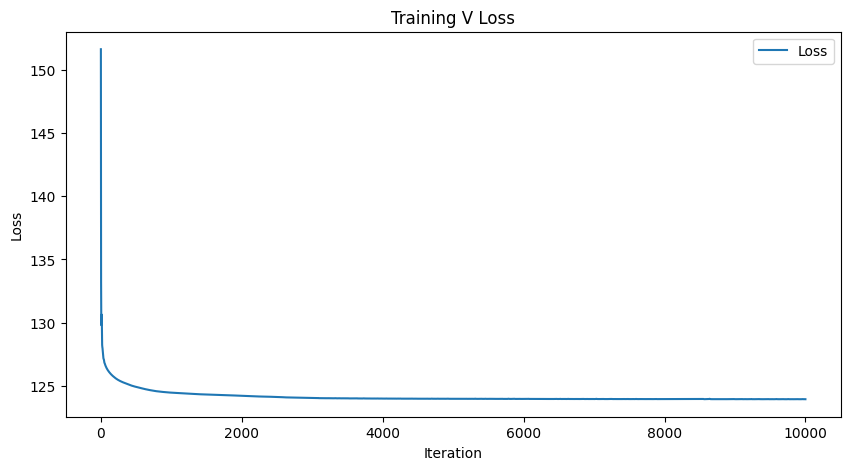

---------------------Sampling Training Data---------------------


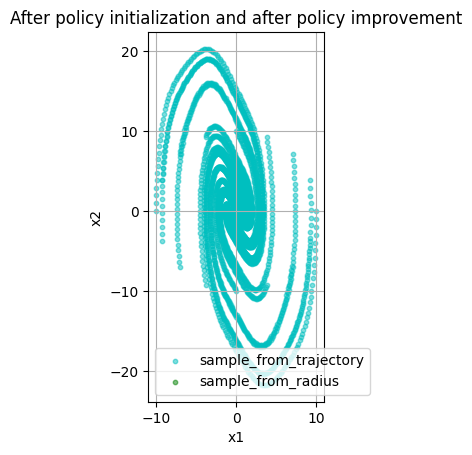

-----------------It takes 425 steps to converge.------------------


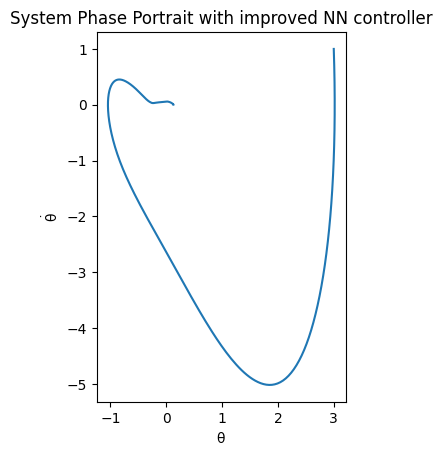

第19次迭代
--------------------------Updating policy by PPO--------------------------


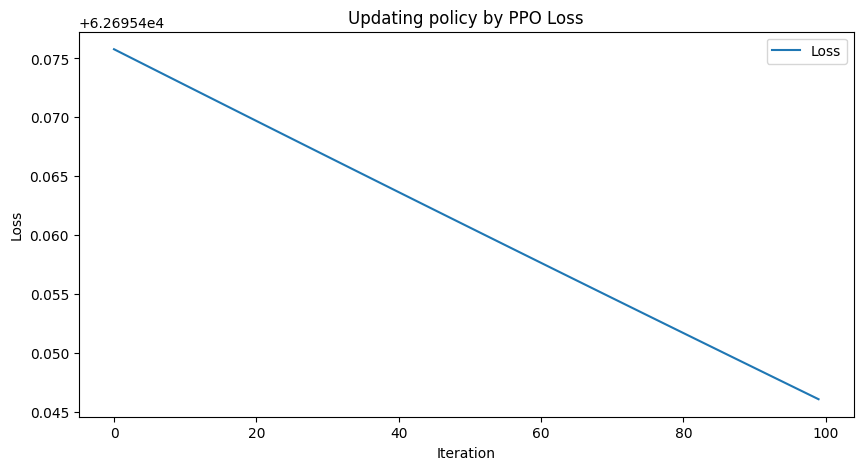

--------------------------Learning Value function--------------------------
Epoch [1000/10000], Loss: 131.0467834473
Epoch [2000/10000], Loss: 130.4389953613
Epoch [3000/10000], Loss: 130.0609588623
Epoch [4000/10000], Loss: 129.9534912109
Epoch [5000/10000], Loss: 129.8955078125
Epoch [6000/10000], Loss: 129.8542480469
Epoch [7000/10000], Loss: 129.8301239014
Epoch [8000/10000], Loss: 129.8175201416
Epoch [9000/10000], Loss: 129.8026123047
Epoch [10000/10000], Loss: 129.7894439697


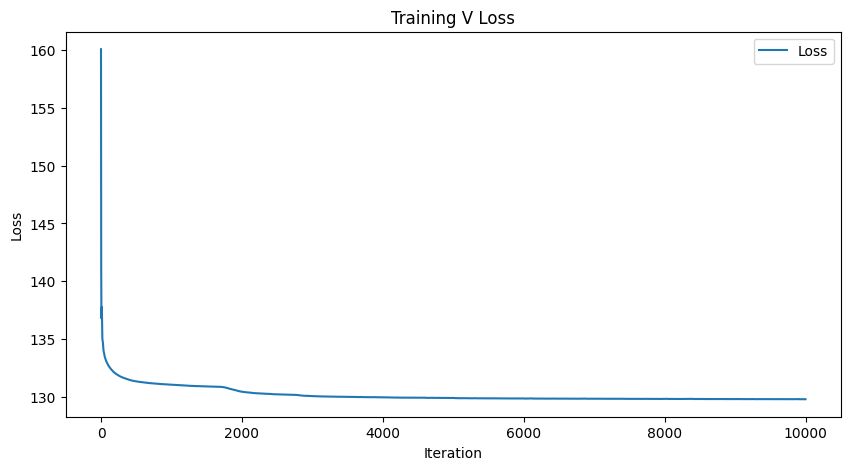

---------------------Sampling Training Data---------------------


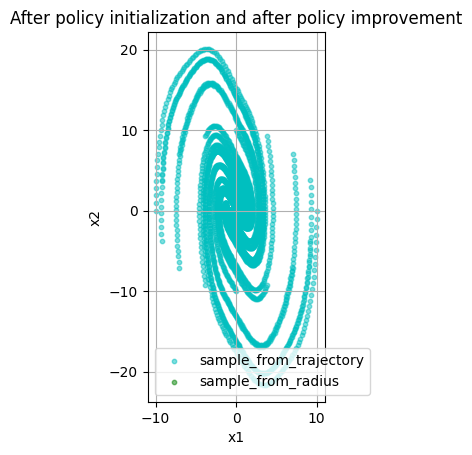

-----------------It takes 726 steps to converge.------------------


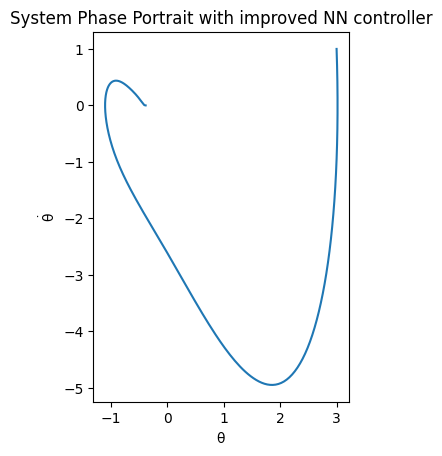

第20次迭代
--------------------------Updating policy by PPO--------------------------


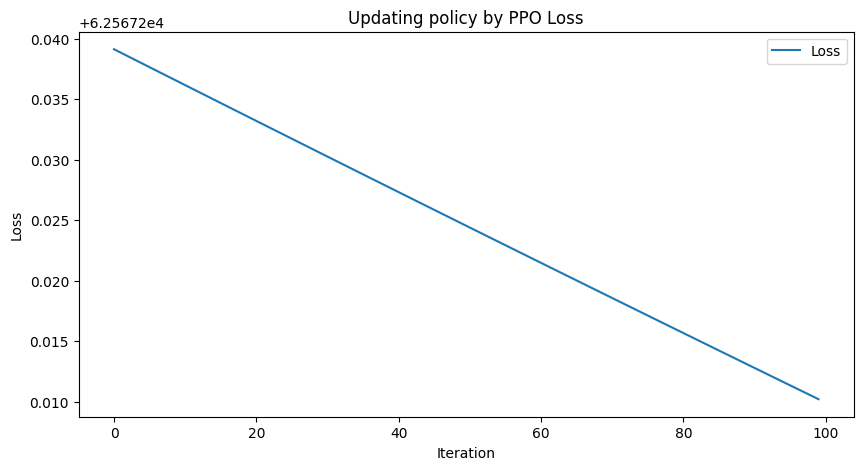

--------------------------Learning Value function--------------------------
Epoch [1000/10000], Loss: 138.4734802246
Epoch [2000/10000], Loss: 137.8239746094
Epoch [3000/10000], Loss: 137.4145355225
Epoch [4000/10000], Loss: 137.1522216797
Epoch [5000/10000], Loss: 136.9525146484
Epoch [6000/10000], Loss: 135.9523925781
Epoch [7000/10000], Loss: 135.5415649414
Epoch [8000/10000], Loss: 135.4572448730
Epoch [9000/10000], Loss: 135.3848419189
Epoch [10000/10000], Loss: 135.3570861816


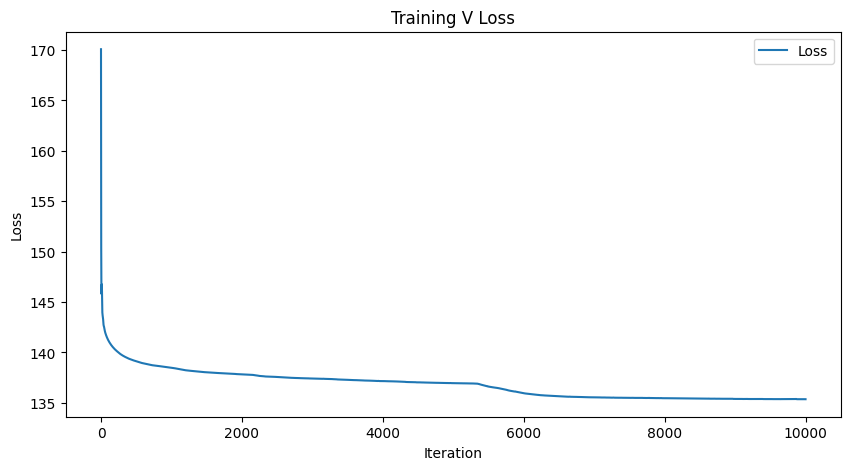

---------------------Sampling Training Data---------------------


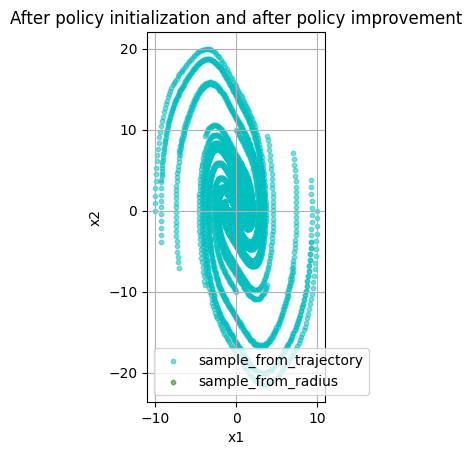

-----------------It takes inf steps to converge.------------------


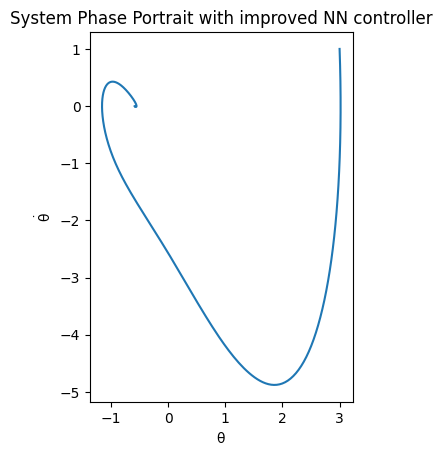

第21次迭代
--------------------------Updating policy by PPO--------------------------


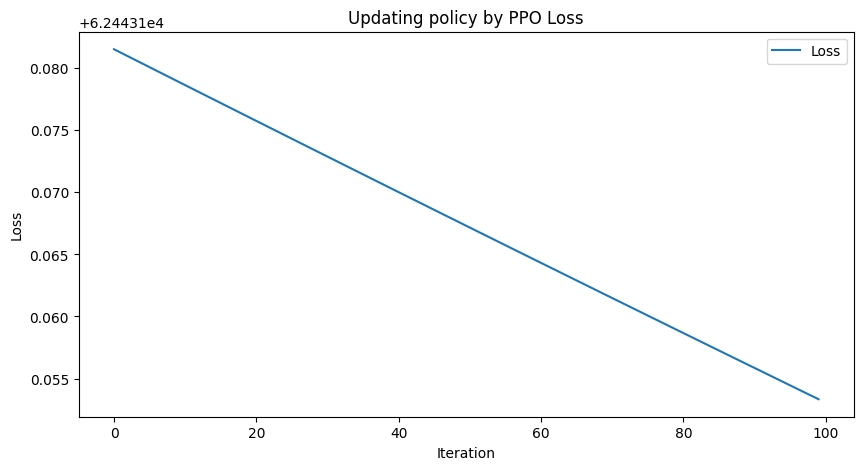

--------------------------Learning Value function--------------------------
Epoch [1000/10000], Loss: 146.3859558105
Epoch [2000/10000], Loss: 146.1848449707
Epoch [3000/10000], Loss: 146.0619964600
Epoch [4000/10000], Loss: 145.9962768555
Epoch [5000/10000], Loss: 145.9129486084
Epoch [6000/10000], Loss: 145.8751373291
Epoch [7000/10000], Loss: 145.8433685303
Epoch [8000/10000], Loss: 145.8255310059
Epoch [9000/10000], Loss: 145.8101196289
Epoch [10000/10000], Loss: 145.7865447998


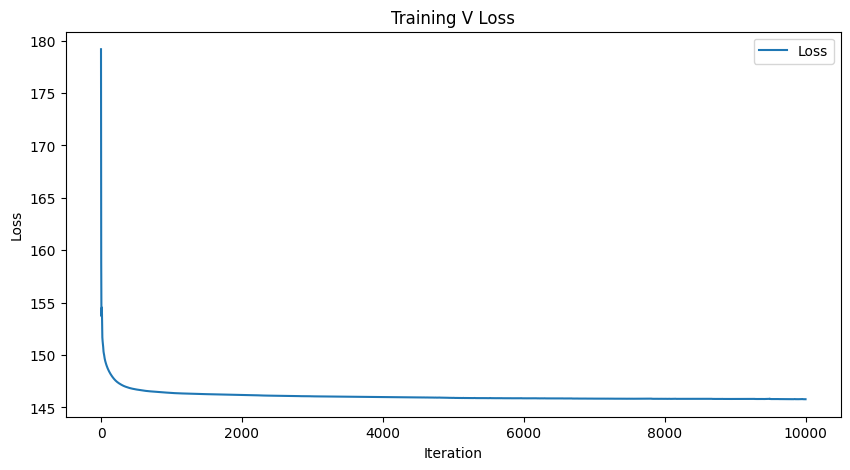

---------------------Sampling Training Data---------------------


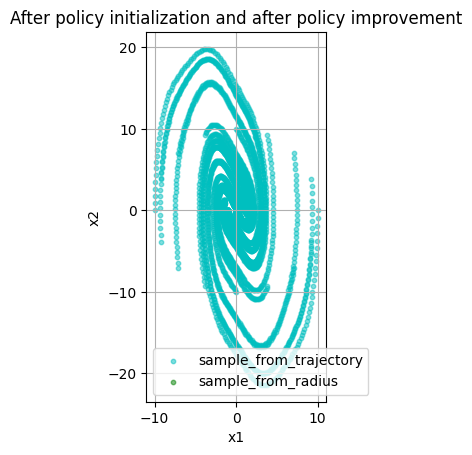

-----------------It takes inf steps to converge.------------------


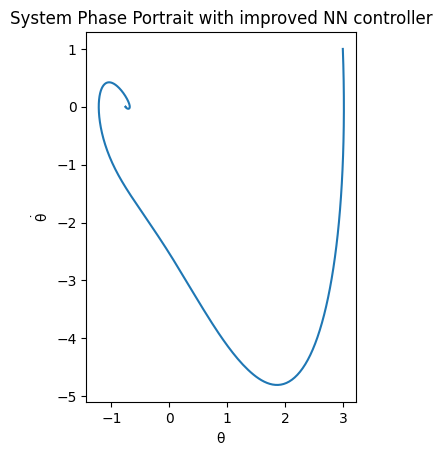

第22次迭代
--------------------------Updating policy by PPO--------------------------


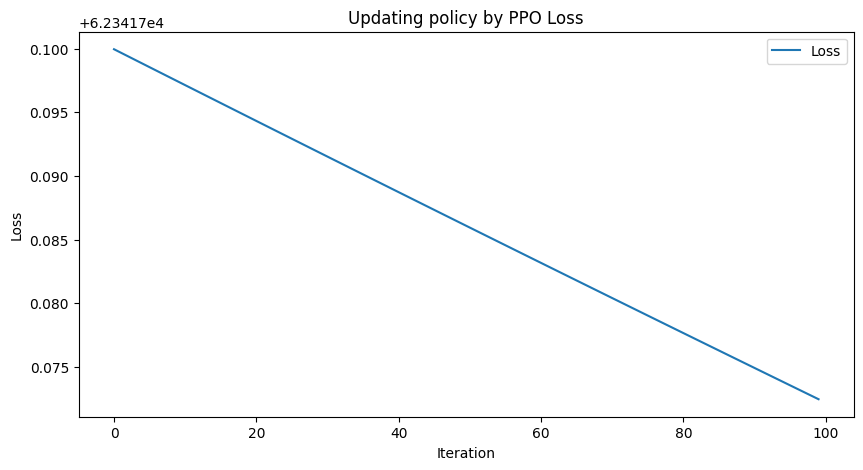

--------------------------Learning Value function--------------------------
Epoch [1000/10000], Loss: 160.1072692871
Epoch [2000/10000], Loss: 159.6791229248
Epoch [3000/10000], Loss: 159.5176849365
Epoch [4000/10000], Loss: 159.4265594482
Epoch [5000/10000], Loss: 159.3518981934
Epoch [6000/10000], Loss: 159.2542724609
Epoch [7000/10000], Loss: 159.2241973877
Epoch [8000/10000], Loss: 159.2084350586
Epoch [9000/10000], Loss: 159.1840820312
Epoch [10000/10000], Loss: 159.1778869629


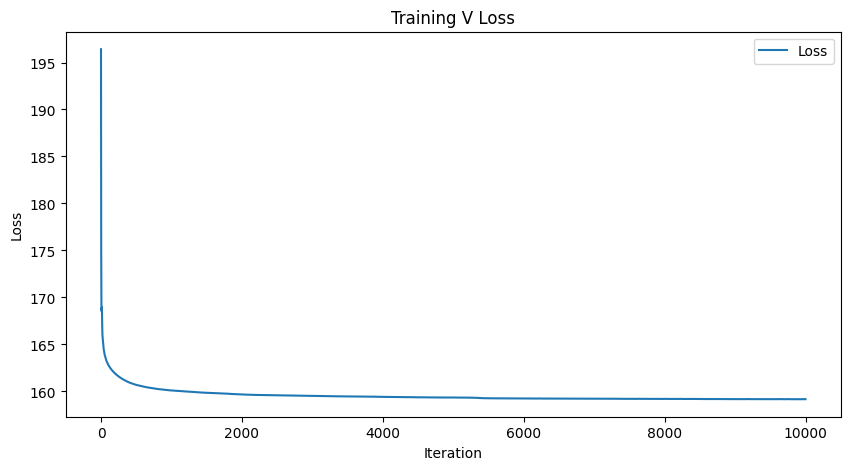

---------------------Sampling Training Data---------------------


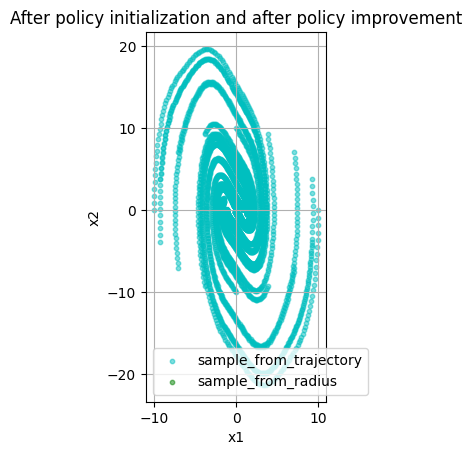

-----------------It takes inf steps to converge.------------------


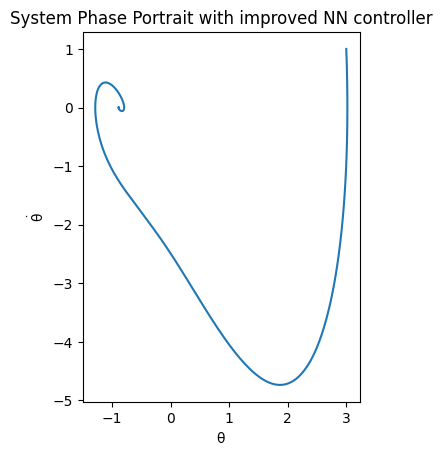

第23次迭代
--------------------------Updating policy by PPO--------------------------


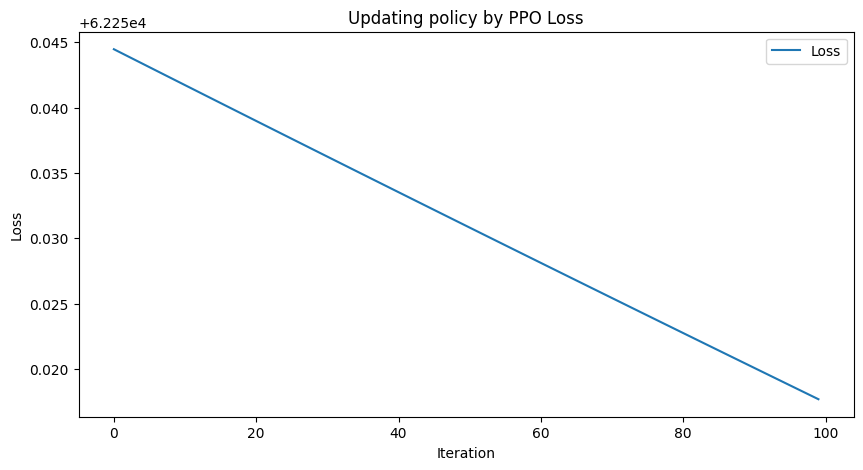

--------------------------Learning Value function--------------------------
Epoch [1000/10000], Loss: 177.0337982178
Epoch [2000/10000], Loss: 176.6340942383
Epoch [3000/10000], Loss: 176.4425354004
Epoch [4000/10000], Loss: 176.3581848145
Epoch [5000/10000], Loss: 176.3093414307
Epoch [6000/10000], Loss: 176.2755126953
Epoch [7000/10000], Loss: 176.2518615723
Epoch [8000/10000], Loss: 176.2341003418
Epoch [9000/10000], Loss: 176.2225189209
Epoch [10000/10000], Loss: 176.2135620117


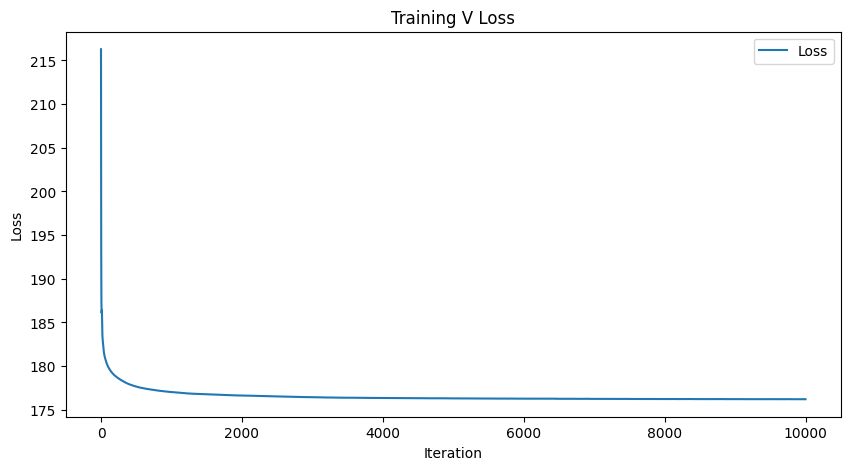

---------------------Sampling Training Data---------------------


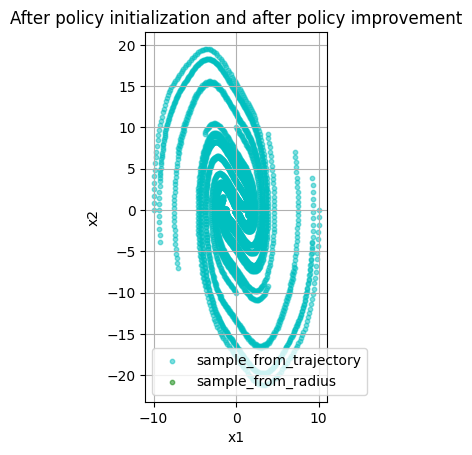

-----------------It takes inf steps to converge.------------------


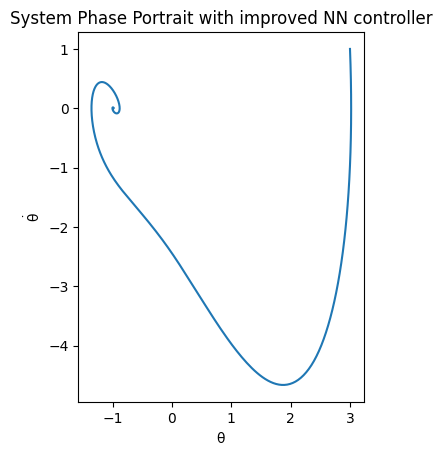

第24次迭代
--------------------------Updating policy by PPO--------------------------


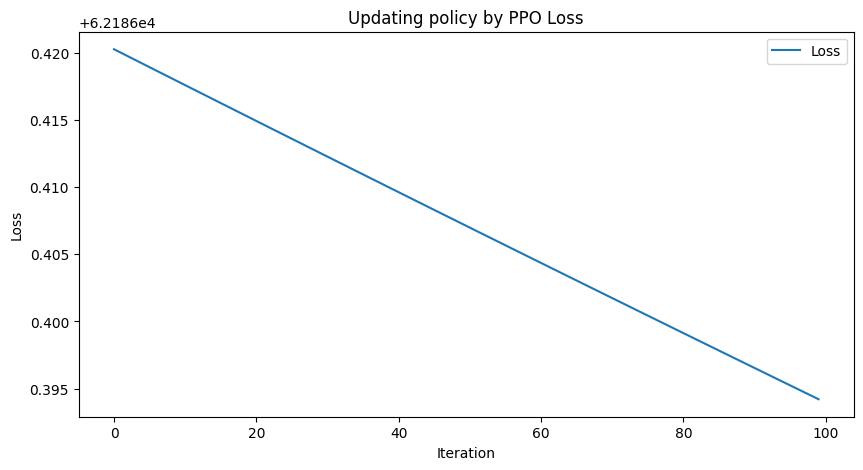

--------------------------Learning Value function--------------------------
Epoch [1000/10000], Loss: 197.0764465332
Epoch [2000/10000], Loss: 196.4505004883
Epoch [3000/10000], Loss: 196.1729736328
Epoch [4000/10000], Loss: 195.9750366211
Epoch [5000/10000], Loss: 195.8362121582
Epoch [6000/10000], Loss: 195.6661224365
Epoch [7000/10000], Loss: 195.6002502441
Epoch [8000/10000], Loss: 195.5700988770
Epoch [9000/10000], Loss: 195.5716552734
Epoch [10000/10000], Loss: 195.5485382080


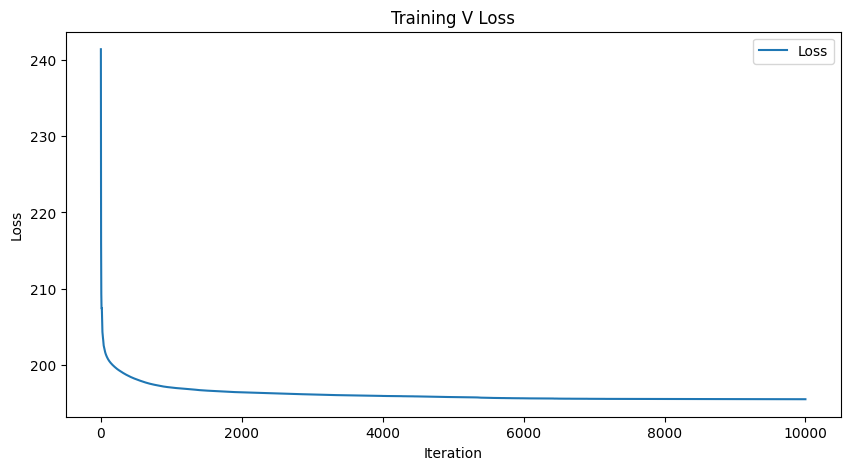

---------------------Sampling Training Data---------------------


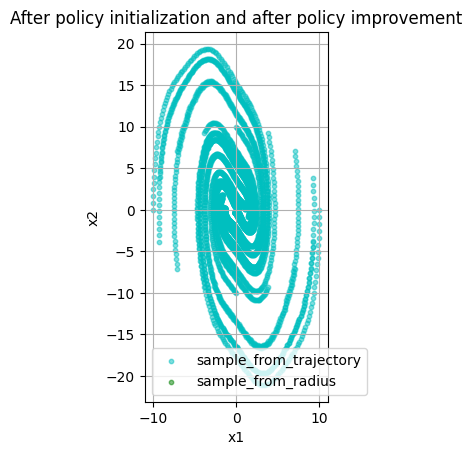

-----------------It takes inf steps to converge.------------------


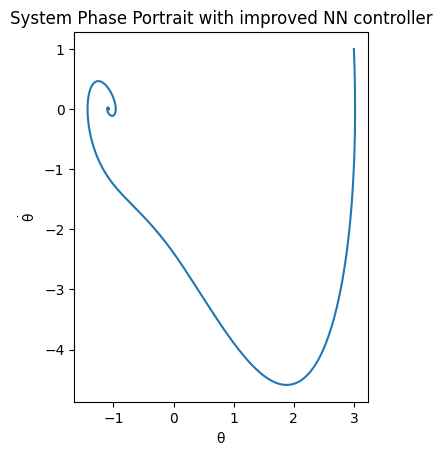

第25次迭代
--------------------------Updating policy by PPO--------------------------


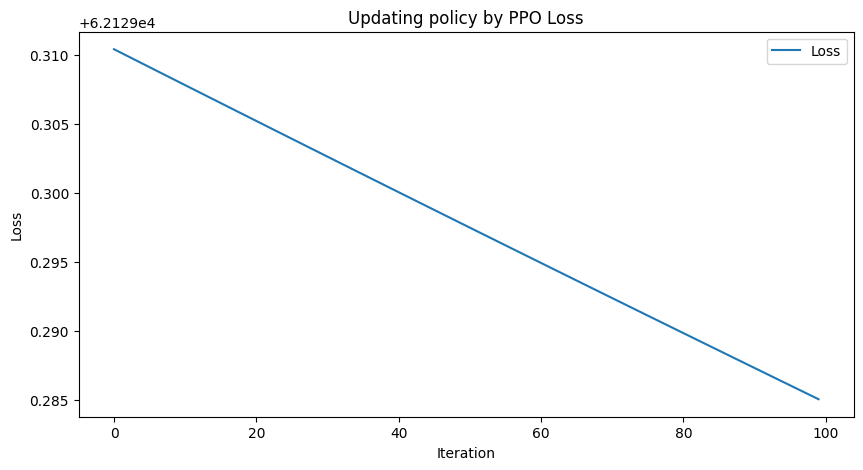

--------------------------Learning Value function--------------------------
Epoch [1000/10000], Loss: 219.7920074463
Epoch [2000/10000], Loss: 219.1310729980
Epoch [3000/10000], Loss: 218.7677917480
Epoch [4000/10000], Loss: 218.5699157715
Epoch [5000/10000], Loss: 218.5293884277
Epoch [6000/10000], Loss: 218.5017089844
Epoch [7000/10000], Loss: 218.4804687500
Epoch [8000/10000], Loss: 218.4604797363
Epoch [9000/10000], Loss: 218.4500274658
Epoch [10000/10000], Loss: 218.4380493164


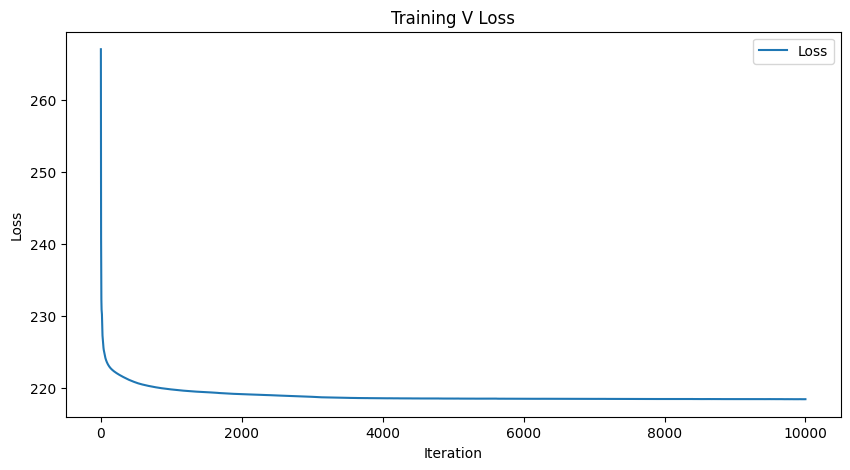

---------------------Sampling Training Data---------------------


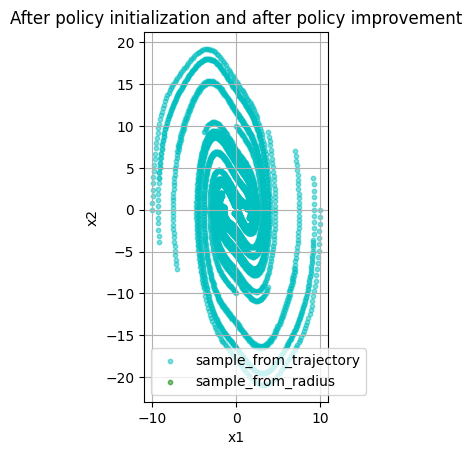

-----------------It takes inf steps to converge.------------------


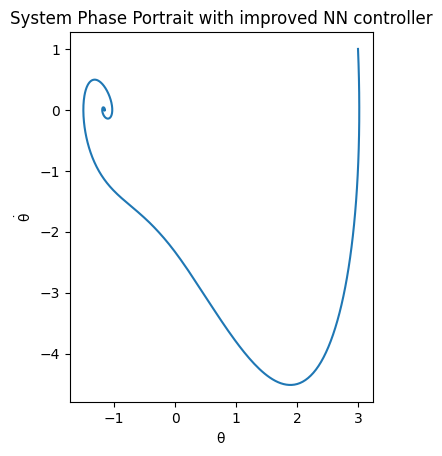

第26次迭代
--------------------------Updating policy by PPO--------------------------


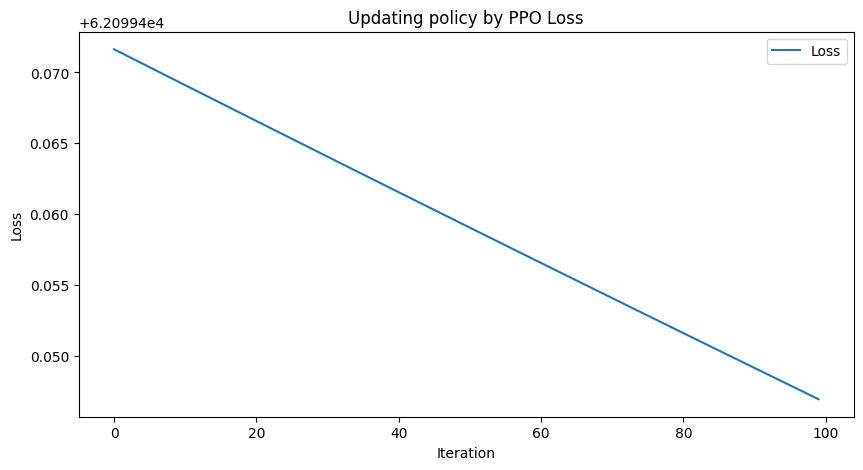

--------------------------Learning Value function--------------------------
Epoch [1000/10000], Loss: 245.6239013672
Epoch [2000/10000], Loss: 244.3093719482
Epoch [3000/10000], Loss: 243.7007141113
Epoch [4000/10000], Loss: 243.4261169434
Epoch [5000/10000], Loss: 243.3664398193
Epoch [6000/10000], Loss: 243.3326416016
Epoch [7000/10000], Loss: 243.2805175781
Epoch [8000/10000], Loss: 243.2074890137
Epoch [9000/10000], Loss: 243.1841735840
Epoch [10000/10000], Loss: 243.1731872559


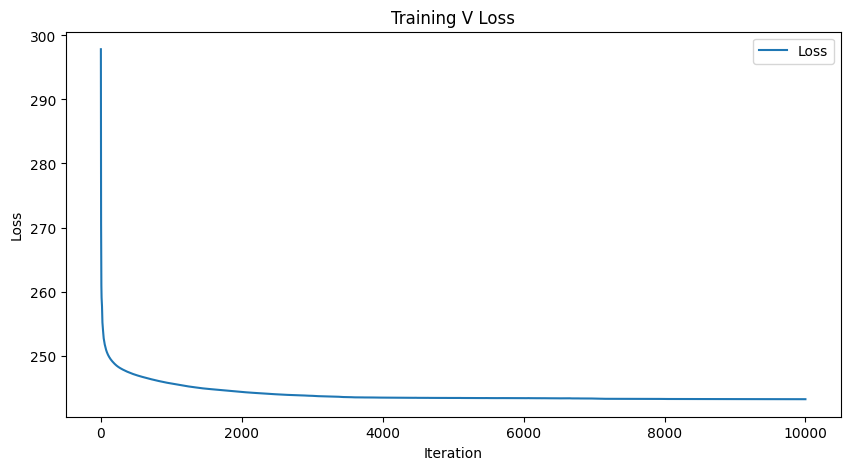

---------------------Sampling Training Data---------------------


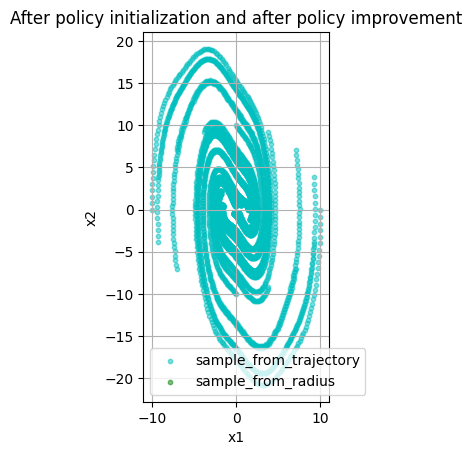

-----------------It takes inf steps to converge.------------------


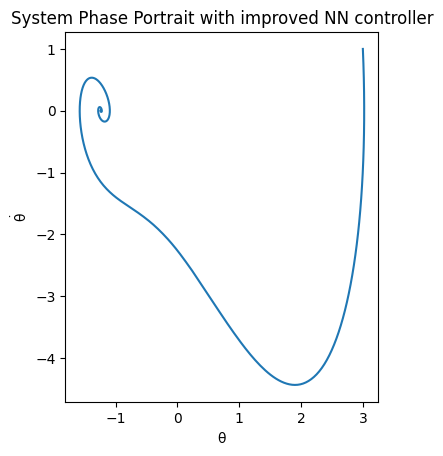

第27次迭代
--------------------------Updating policy by PPO--------------------------


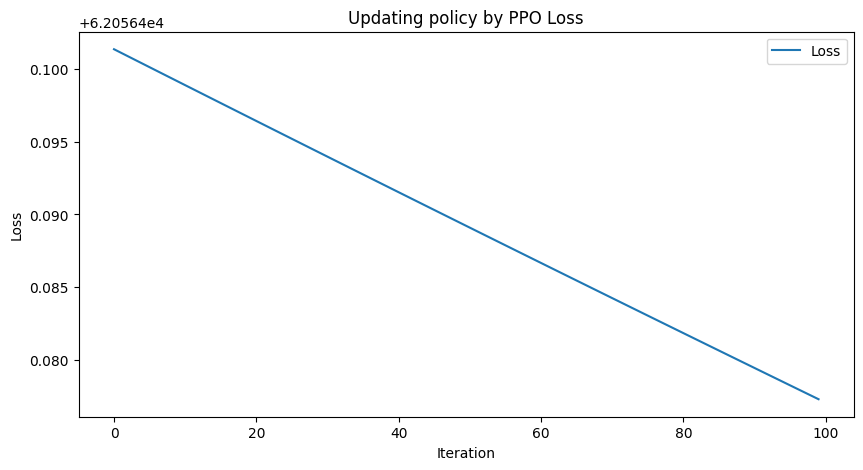

--------------------------Learning Value function--------------------------
Epoch [1000/10000], Loss: 273.9084777832
Epoch [2000/10000], Loss: 272.8032531738
Epoch [3000/10000], Loss: 272.3463439941
Epoch [4000/10000], Loss: 272.0919494629
Epoch [5000/10000], Loss: 271.8277587891
Epoch [6000/10000], Loss: 271.7174682617
Epoch [7000/10000], Loss: 271.6729125977
Epoch [8000/10000], Loss: 271.6447448730
Epoch [9000/10000], Loss: 271.6246643066
Epoch [10000/10000], Loss: 271.6150512695


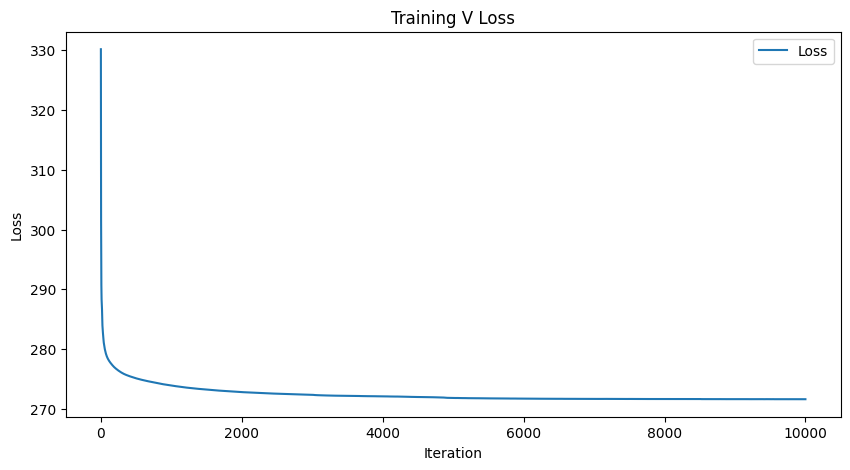

---------------------Sampling Training Data---------------------


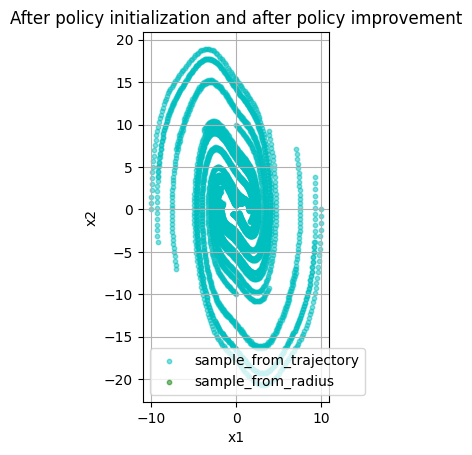

-----------------It takes inf steps to converge.------------------


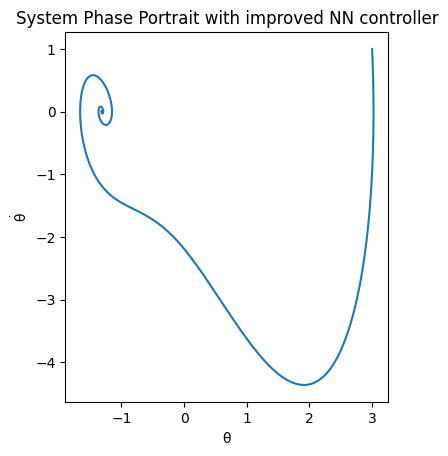

第28次迭代
--------------------------Updating policy by PPO--------------------------


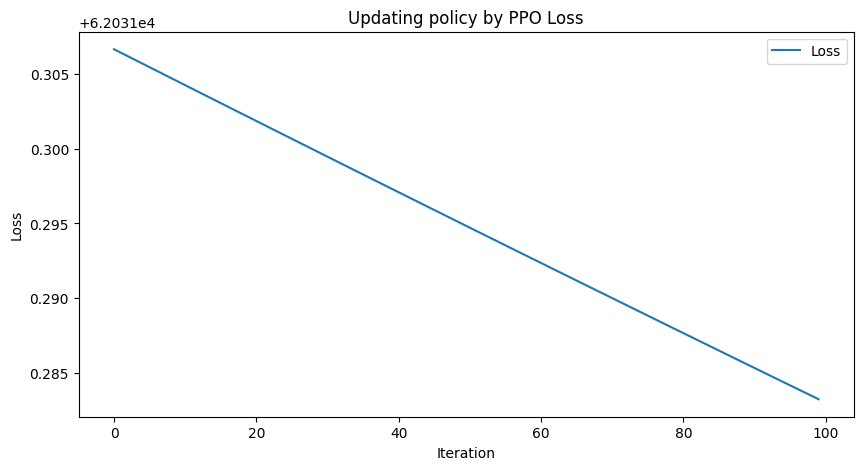

--------------------------Learning Value function--------------------------
Epoch [1000/10000], Loss: 306.9975585938
Epoch [2000/10000], Loss: 305.6236267090
Epoch [3000/10000], Loss: 304.9426879883
Epoch [4000/10000], Loss: 304.7315368652
Epoch [5000/10000], Loss: 304.6406555176
Epoch [6000/10000], Loss: 304.5846862793
Epoch [7000/10000], Loss: 303.9648437500
Epoch [8000/10000], Loss: 303.8829956055
Epoch [9000/10000], Loss: 303.8611450195
Epoch [10000/10000], Loss: 303.8504638672


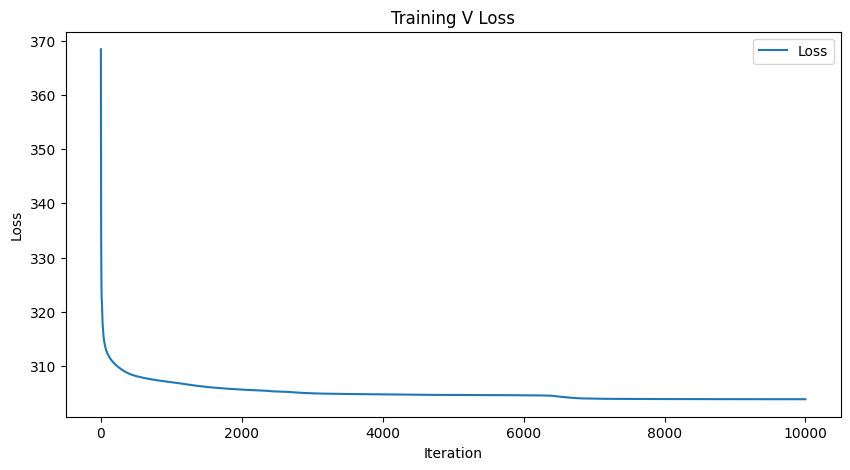

---------------------Sampling Training Data---------------------


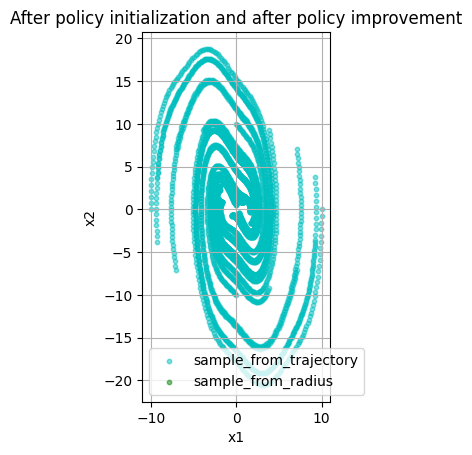

-----------------It takes inf steps to converge.------------------


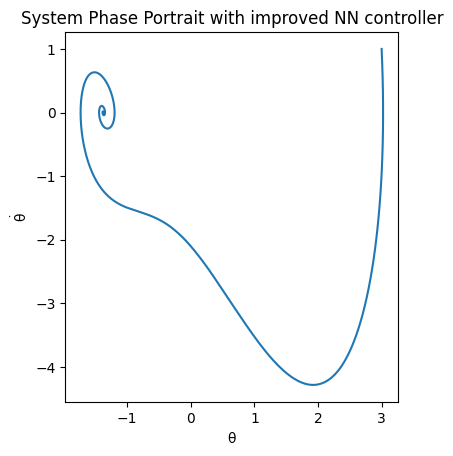

第29次迭代
--------------------------Updating policy by PPO--------------------------


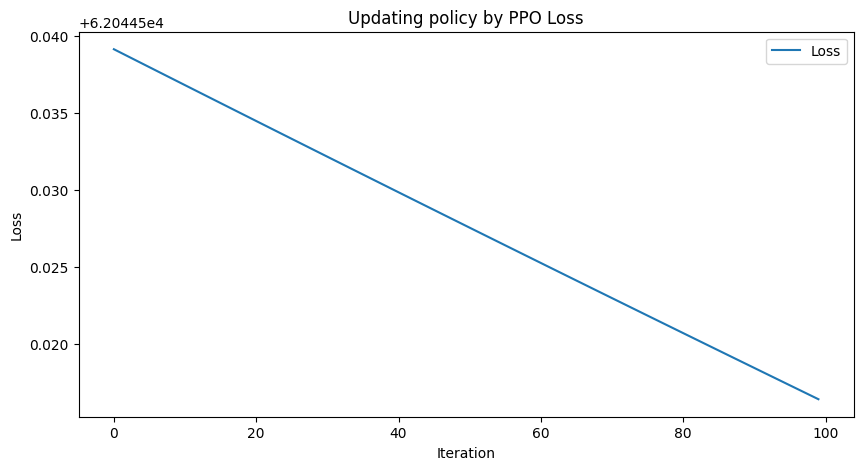

--------------------------Learning Value function--------------------------
Epoch [1000/10000], Loss: 346.3017272949
Epoch [2000/10000], Loss: 345.3618469238
Epoch [3000/10000], Loss: 345.0726013184
Epoch [4000/10000], Loss: 344.9884643555
Epoch [5000/10000], Loss: 344.9474792480
Epoch [6000/10000], Loss: 344.9274902344
Epoch [7000/10000], Loss: 344.9078674316
Epoch [8000/10000], Loss: 344.8991699219
Epoch [9000/10000], Loss: 344.9039306641
Epoch [10000/10000], Loss: 344.8595275879


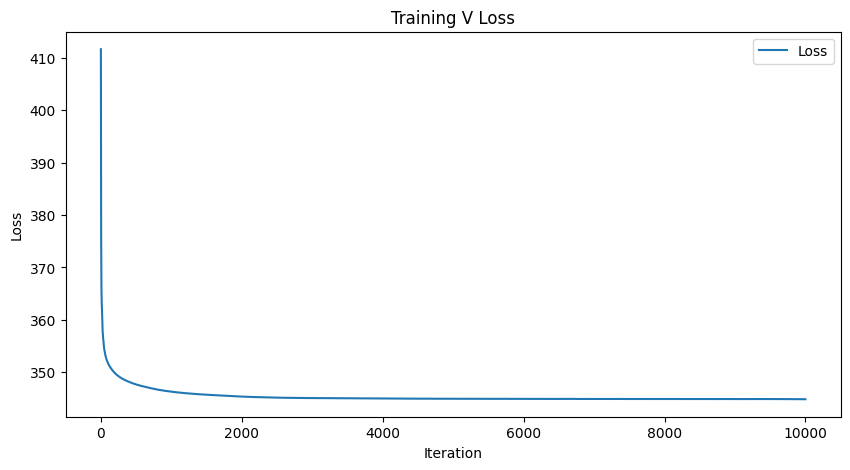

---------------------Sampling Training Data---------------------


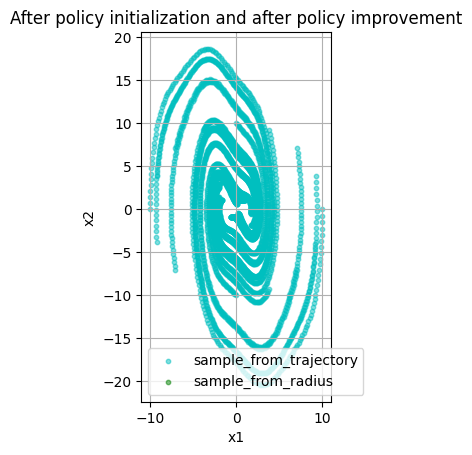

-----------------It takes inf steps to converge.------------------


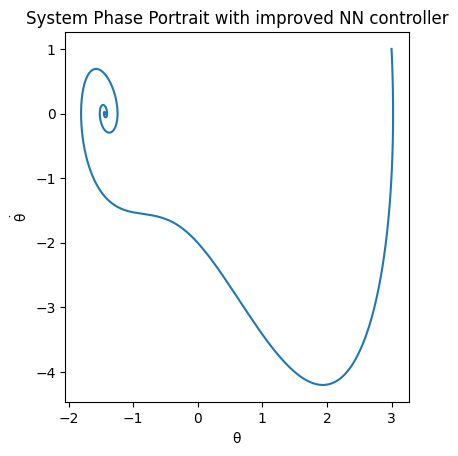

第30次迭代
--------------------------Updating policy by PPO--------------------------


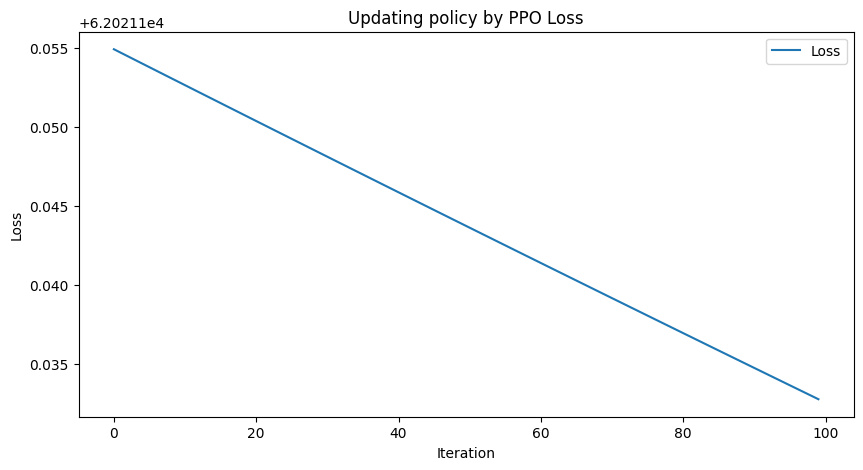

--------------------------Learning Value function--------------------------
Epoch [1000/10000], Loss: 400.9187622070
Epoch [2000/10000], Loss: 400.0224914551
Epoch [3000/10000], Loss: 399.7277526855
Epoch [4000/10000], Loss: 399.5958251953
Epoch [5000/10000], Loss: 399.5232543945
Epoch [6000/10000], Loss: 399.4817810059
Epoch [7000/10000], Loss: 399.4223632812
Epoch [8000/10000], Loss: 399.3959960938
Epoch [9000/10000], Loss: 399.3769531250
Epoch [10000/10000], Loss: 399.3718261719


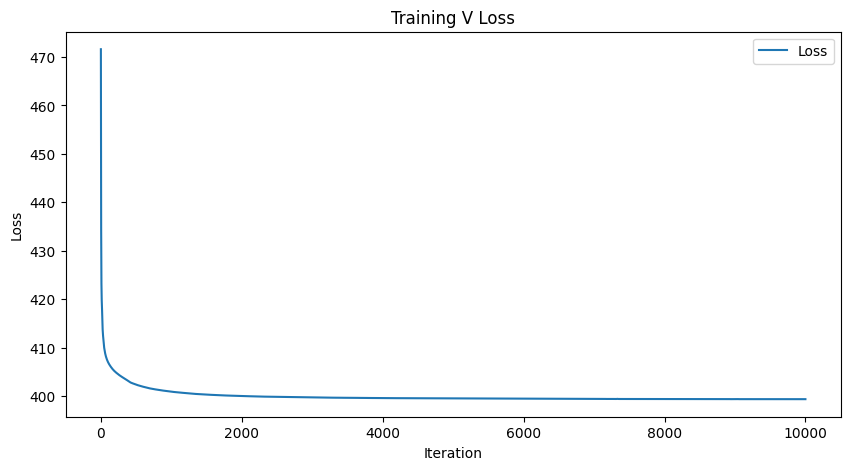

---------------------Sampling Training Data---------------------


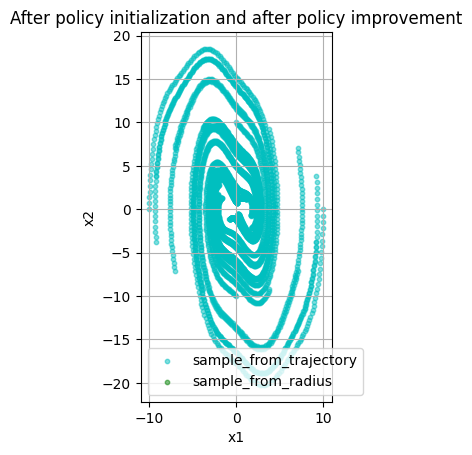

-----------------It takes inf steps to converge.------------------


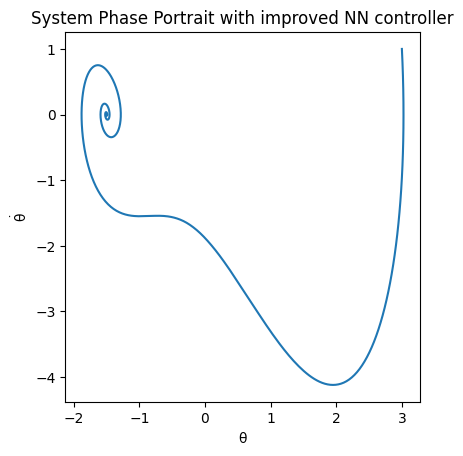

第31次迭代
--------------------------Updating policy by PPO--------------------------


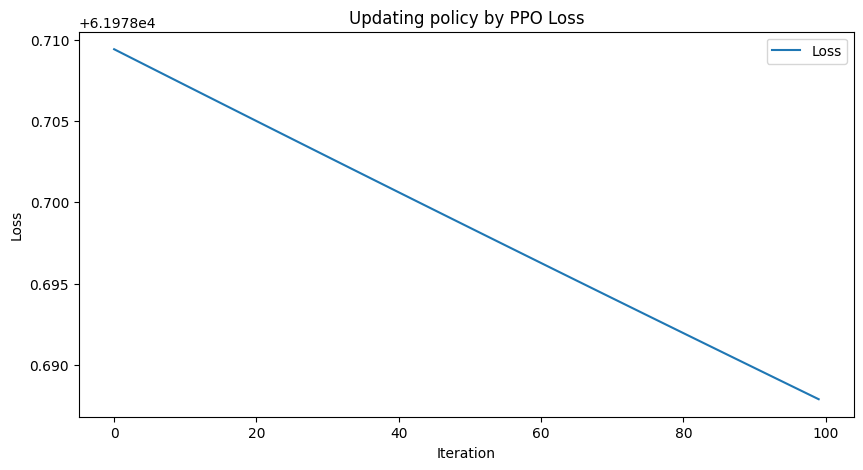

--------------------------Learning Value function--------------------------
Epoch [1000/10000], Loss: 475.3122558594
Epoch [2000/10000], Loss: 473.9890441895
Epoch [3000/10000], Loss: 473.5267944336
Epoch [4000/10000], Loss: 473.2152404785
Epoch [5000/10000], Loss: 472.9862060547
Epoch [6000/10000], Loss: 472.8283081055
Epoch [7000/10000], Loss: 472.6797180176
Epoch [8000/10000], Loss: 472.5686645508
Epoch [9000/10000], Loss: 472.5182495117
Epoch [10000/10000], Loss: 472.4870605469


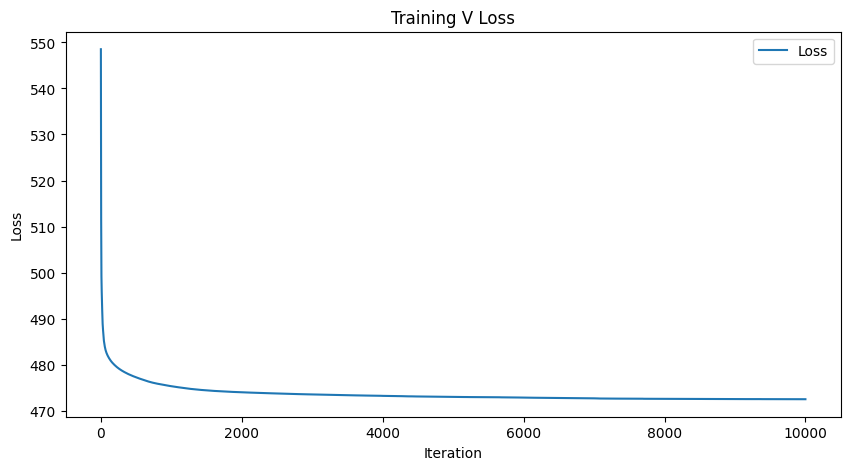

---------------------Sampling Training Data---------------------


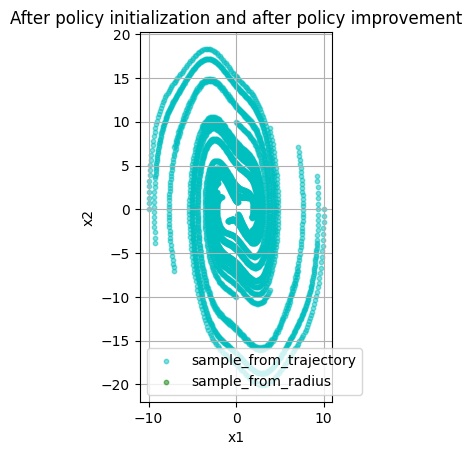

-----------------It takes inf steps to converge.------------------


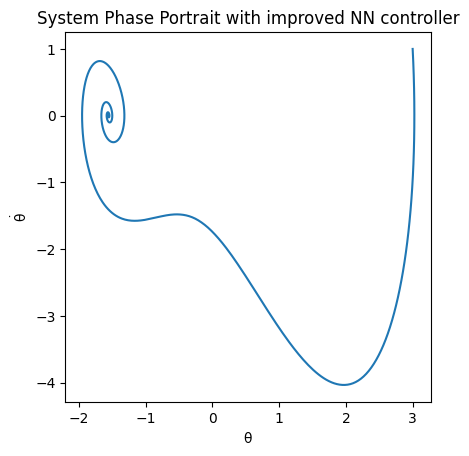

第32次迭代
--------------------------Updating policy by PPO--------------------------


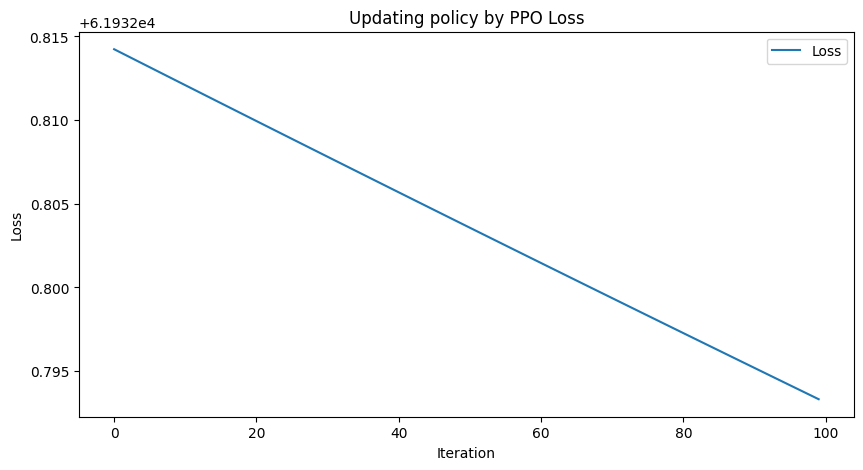

--------------------------Learning Value function--------------------------
Epoch [1000/10000], Loss: 573.1375732422
Epoch [2000/10000], Loss: 571.7935180664
Epoch [3000/10000], Loss: 571.0543823242
Epoch [4000/10000], Loss: 570.5300292969
Epoch [5000/10000], Loss: 570.2338256836
Epoch [6000/10000], Loss: 570.0417480469
Epoch [7000/10000], Loss: 569.8923339844
Epoch [8000/10000], Loss: 569.7706909180
Epoch [9000/10000], Loss: 569.7013549805
Epoch [10000/10000], Loss: 569.6740112305


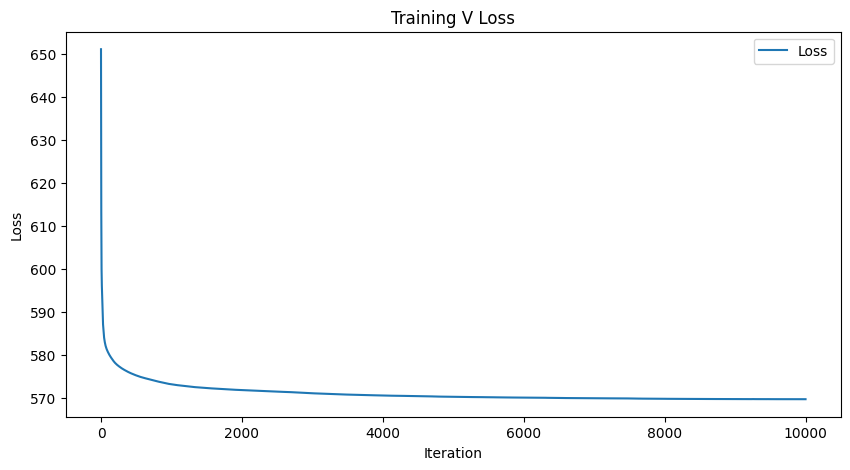

---------------------Sampling Training Data---------------------


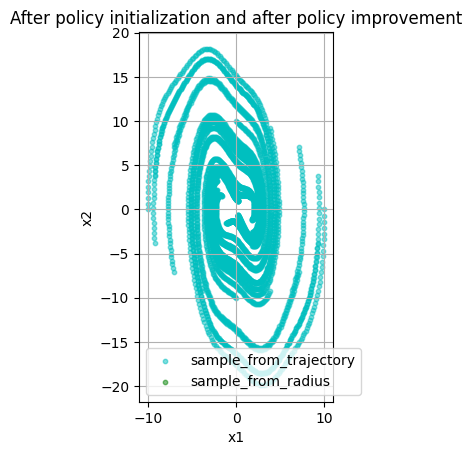

-----------------It takes inf steps to converge.------------------


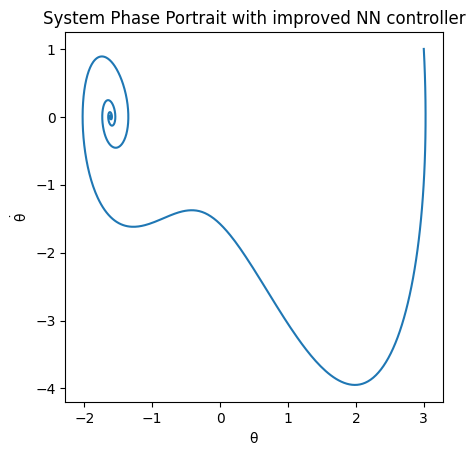

第33次迭代
--------------------------Updating policy by PPO--------------------------


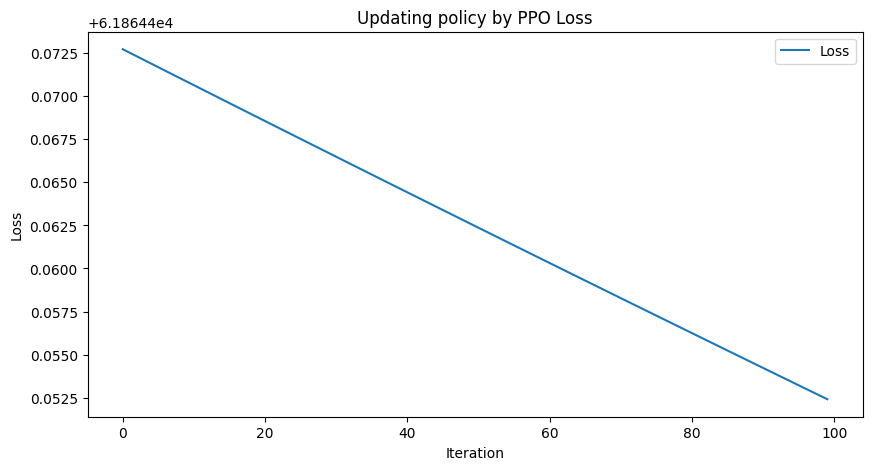

--------------------------Learning Value function--------------------------
Epoch [1000/10000], Loss: 700.1864624023
Epoch [2000/10000], Loss: 698.4429931641
Epoch [3000/10000], Loss: 697.9216918945
Epoch [4000/10000], Loss: 696.5154418945
Epoch [5000/10000], Loss: 695.0779418945
Epoch [6000/10000], Loss: 694.7930908203
Epoch [7000/10000], Loss: 694.6778564453
Epoch [8000/10000], Loss: 694.6009521484
Epoch [9000/10000], Loss: 694.5606689453
Epoch [10000/10000], Loss: 694.5347290039


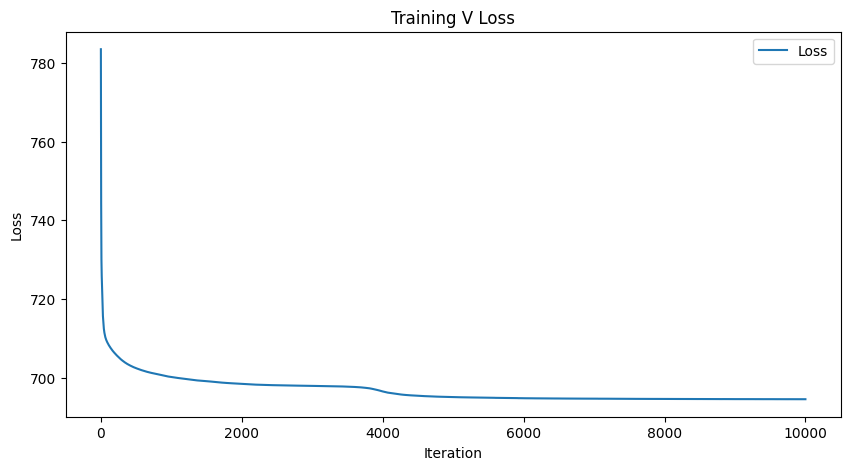

---------------------Sampling Training Data---------------------


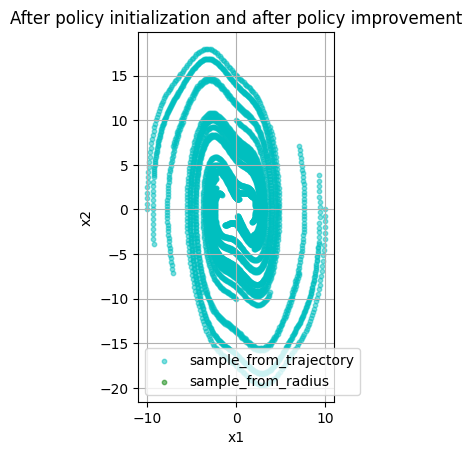

-----------------It takes inf steps to converge.------------------


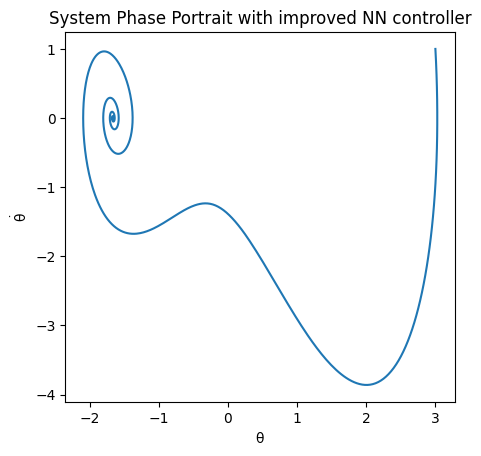

第34次迭代
--------------------------Updating policy by PPO--------------------------


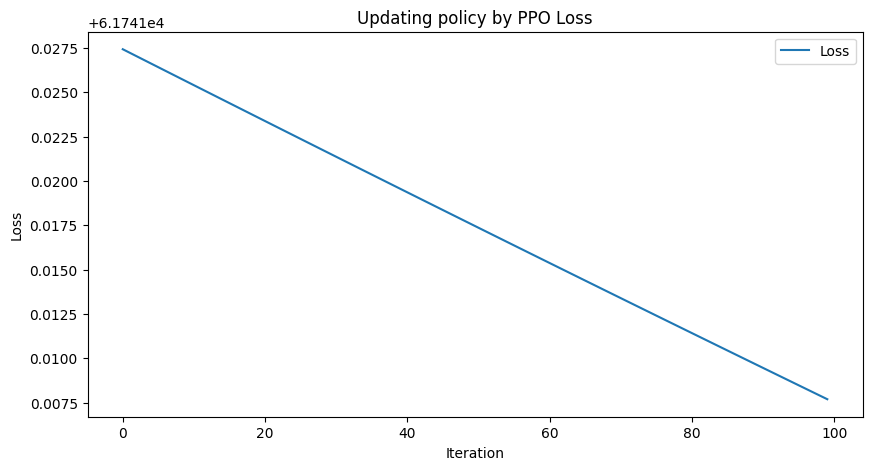

--------------------------Learning Value function--------------------------
Epoch [1000/10000], Loss: 855.4282836914
Epoch [2000/10000], Loss: 853.2204589844
Epoch [3000/10000], Loss: 852.4225463867
Epoch [4000/10000], Loss: 852.0093994141
Epoch [5000/10000], Loss: 851.9102783203
Epoch [6000/10000], Loss: 851.8242187500
Epoch [7000/10000], Loss: 851.7214355469
Epoch [8000/10000], Loss: 851.6887817383
Epoch [9000/10000], Loss: 851.6720581055
Epoch [10000/10000], Loss: 851.6513061523


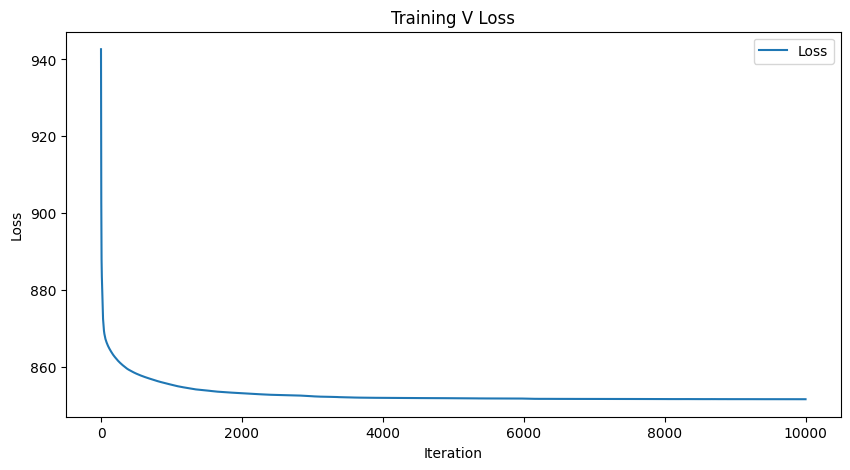

---------------------Sampling Training Data---------------------


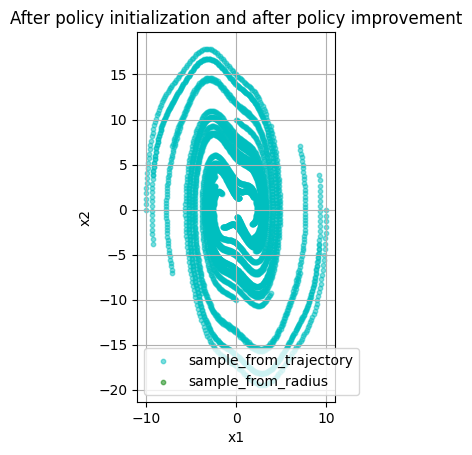

-----------------It takes inf steps to converge.------------------


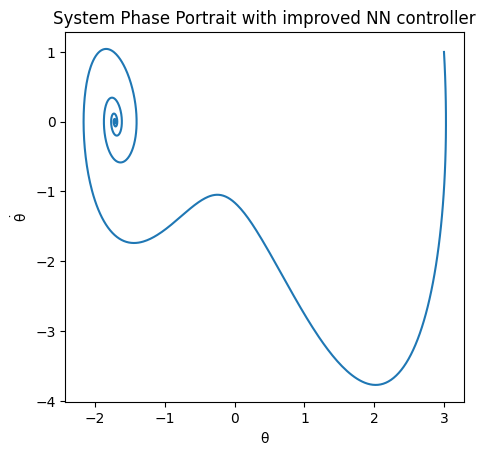

第35次迭代
--------------------------Updating policy by PPO--------------------------


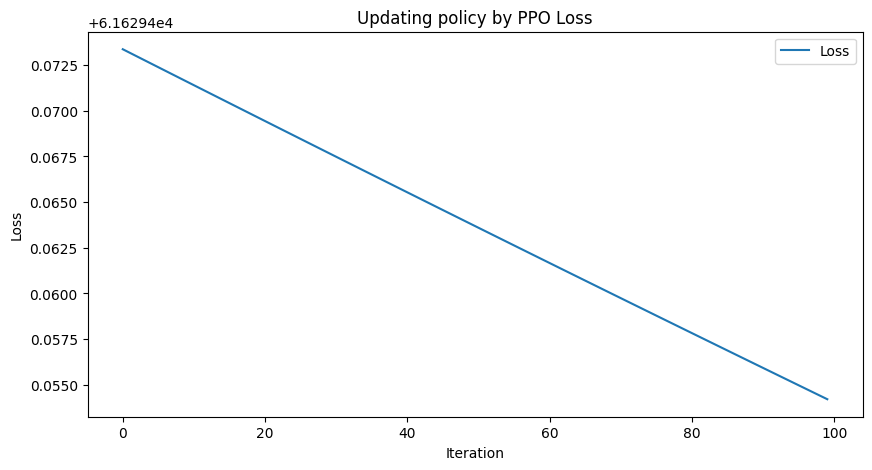

--------------------------Learning Value function--------------------------
Epoch [1000/10000], Loss: 1048.2869873047
Epoch [2000/10000], Loss: 1044.5794677734
Epoch [3000/10000], Loss: 1043.5538330078
Epoch [4000/10000], Loss: 1043.0292968750
Epoch [5000/10000], Loss: 1042.7061767578
Epoch [6000/10000], Loss: 1042.5123291016
Epoch [7000/10000], Loss: 1042.2583007812
Epoch [8000/10000], Loss: 1042.1289062500
Epoch [9000/10000], Loss: 1042.0502929688
Epoch [10000/10000], Loss: 1041.9995117188


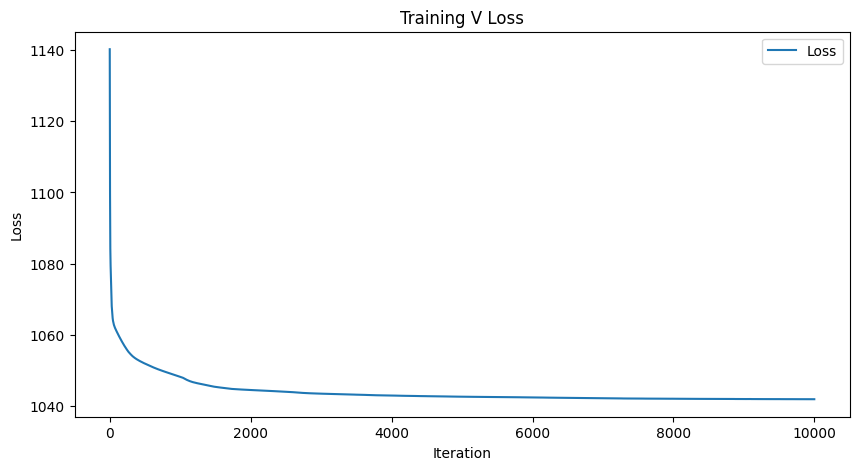

---------------------Sampling Training Data---------------------


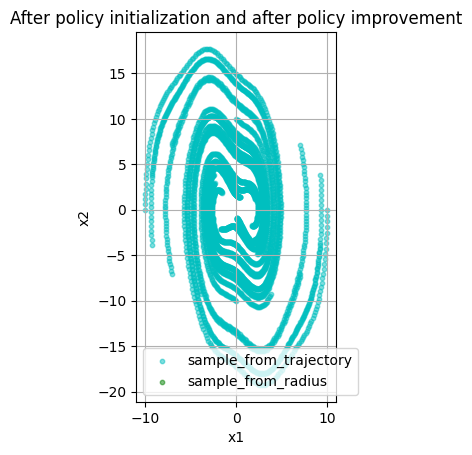

-----------------It takes inf steps to converge.------------------


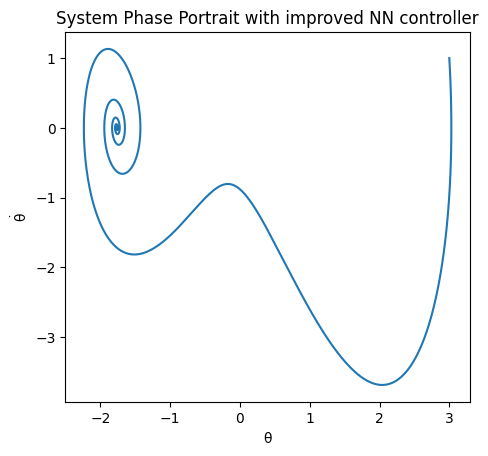

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


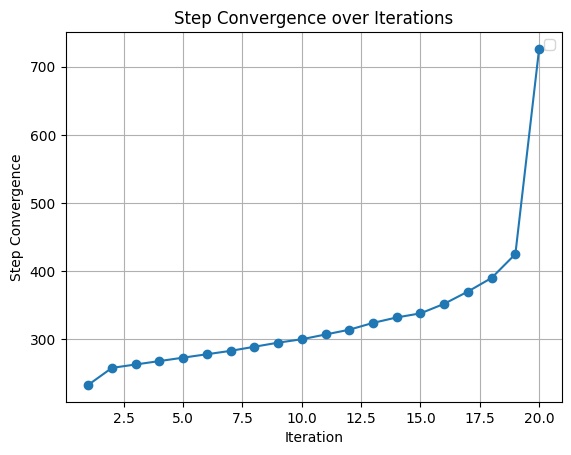

In [6]:
# 创建一个空列表来存储每次迭代的 stepconverge 值
stepconverge_list = []
stepconverge_list.append(stepconverge_initial)

for i in range(35):
    print(f"第{i+1}次迭代")
    
    d1.update_policy_PPO(sample_data = sim_data,
                actions = actions,
                iteration= 10**2,
                lr= 0.0001,
                plot_loss= True)
    
    d1.learn_Valuefunction(sample_data = sim_data,
                        actions = actions,
                        iteration = 10**4,
                        lr = 0.001,
                        sample_number_per_trajectory = sample_number_per_trajectory,
                        gamma = 0.98,
                        plot_loss = True)

    [sim_data,actions] = d1.sample_training_data(sample_trajectory_number = 16,
                                sample_number_per_trajectory = sample_number_per_trajectory,
                                sample_radius = 10,
                                sample_number_in_radius = 0,
                                invariant_sample = 1,
                                sample_plot = 1,
                                the_controller = d1.actor.Controller,
                                title = 'After policy improvement')

    x_initial = torch.tensor([[3],[1]]).to(device)
    step_num = 4000
    sim_data_ = p1.simulate_rk4(x_initial = x_initial, 
                            step_number = step_num,
                            use_controller = 1,
                            the_controller = d1.actor.Controller)
    
    stepconverge = p1.convergence_judgment(sim_data_)
    stepconverge_list.append(stepconverge)  # 将每次迭代的 stepconverge 值添加到列表中

    p1.plot_phase_portrait(data_sim = sim_data_,
                        arrow_on = False,
                        title = 'System Phase Portrait with improved NN controller')
  
        
# 绘制 stepconverge 值随迭代次数变化的折线图
plt.figure()
plt.plot(range(1, len(stepconverge_list) + 1), stepconverge_list, marker='o')
plt.xlabel('Iteration')
plt.ylabel('Step Convergence')
plt.title('Step Convergence over Iterations')
plt.grid(True)
plt.legend()  # Show legend with added line
plt.show()

# 保存 stepconverge_list 到文件
with open('result/stepconverge_list_PPO.pk', 'wb') as f:
    pickle.dump(stepconverge_list, f)